In [5]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [6]:
import os
import sqlite3

# Load from SQLite database
db_path = os.path.expanduser('/home/armin/datalake/data-samples/11-24-2025-15m-data-lake.db')
conn = sqlite3.connect(db_path)

# Sample 10,000 random blocks to maintain block structure
print("Sampling blocks from database...")
blocks_query = """
SELECT DISTINCT conf_block_hash 
FROM mempool_transactions 
WHERE conf_block_hash IS NOT NULL
ORDER BY RANDOM()
LIMIT 2000
"""
sampled_blocks = pd.read_sql_query(blocks_query, conn)['conf_block_hash'].tolist()
print(f"Sampled {len(sampled_blocks)} unique blocks")

# Load all transactions from sampled blocks
placeholders = ','.join(['?' for _ in sampled_blocks])
query = f"""
SELECT * FROM mempool_transactions 
WHERE conf_block_hash IN ({placeholders})
"""
print("Loading transactions...")
txs = pd.read_sql_query(query, conn, params=sampled_blocks)
conn.close()

print(f"Loaded {len(txs):,} transactions from {len(sampled_blocks):,} blocks")

Sampling blocks from database...
Sampled 2000 unique blocks
Loading transactions...
Loaded 5,034,861 transactions from 2,000 blocks


In [7]:
# Display all the columns
print(txs.columns)


Index(['id', 'tx_id', 'inputs_hash', 'child_txid', 'tx_data', 'output_amounts',
       'output_weights', 'conf_block_hash', 'found_at', 'mined_at',
       'pruned_at', 'rbf_fee_total', 'min_respend_blocks', 'absolute_fee',
       'fee_rate', 'version', 'seen_in_mempool', 'waittime', 'weight', 'size',
       'total_output_amount', 'mempool_size', 'mempool_tx_count'],
      dtype='object')


In [8]:
# Examine the rbf_fee_total column
print("RBF Fee Total Analysis:")
print(f"Data type: {txs['rbf_fee_total'].dtype}")
print(f"\nBasic statistics:")
print(txs['rbf_fee_total'].describe())
print(f"\nUnique values count: {txs['rbf_fee_total'].nunique()}")
print(f"Null values: {txs['rbf_fee_total'].isna().sum()}")
print(f"\nValue counts (top 20):")
print(txs['rbf_fee_total'].value_counts().head(20))
print(f"\nMin: {txs['rbf_fee_total'].min()}")
print(f"Max: {txs['rbf_fee_total'].max()}")

# Check if it could be a binary flag
unique_vals = txs['rbf_fee_total'].dropna().unique()
print(f"\nIs it binary? {len(unique_vals) == 2 and set(unique_vals).issubset({0, 1})}")

# Create a proper RBF flag if needed
txs['rbf_flag'] = (txs['rbf_fee_total'] > 0).astype(int)
print(f"\nCreated 'rbf_flag' as binary indicator:")
print(f"  Transactions with RBF (rbf_flag=1): {(txs['rbf_flag'] == 1).sum():,} ({(txs['rbf_flag'] == 1).sum()/len(txs)*100:.2f}%)")
print(f"  Transactions without RBF (rbf_flag=0): {(txs['rbf_flag'] == 0).sum():,} ({(txs['rbf_flag'] == 0).sum()/len(txs)*100:.2f}%)")


RBF Fee Total Analysis:
Data type: float64

Basic statistics:
count    4.140000e+04
mean     1.952382e+03
std      8.587410e+03
min      0.000000e+00
25%      5.230000e+02
50%      8.760000e+02
75%      1.644000e+03
max      1.296000e+06
Name: rbf_fee_total, dtype: float64

Unique values count: 5794
Null values: 4993461

Value counts (top 20):
rbf_fee_total
280.0     1025
705.0      428
423.0      333
846.0      291
312.0      286
286.0      286
282.0      272
564.0      259
585.0      258
440.0      253
330.0      249
999.0      237
550.0      221
1410.0     210
1128.0     209
364.0      192
645.0      191
876.0      183
407.0      180
1178.0     180
Name: count, dtype: int64

Min: 0.0
Max: 1296000.0

Is it binary? False

Created 'rbf_flag' as binary indicator:
  Transactions with RBF (rbf_flag=1): 41,398 (0.82%)
  Transactions without RBF (rbf_flag=0): 4,993,463 (99.18%)


In [9]:
# Simple questions to ensure our data is sane before we start building models
# 1. How many transactions are in the dataset?
print(f"Number of transactions: {len(txs)}")

# 2. What is the average wait time?
avg_waittime = txs['waittime'].mean()
print(f"Average wait time: {int(avg_waittime)} seconds, {int(avg_waittime/60)} minutes")

# Median wait time
median_waittime = txs['waittime'].median()
print(f"Median wait time: {int(median_waittime)} seconds, {int(median_waittime/60)} minutes")

# 3. What is the average mempool size?
avg_mempool_size = txs['mempool_size'].mean()
print(f"Average mempool size: {int(avg_mempool_size)}")

# 4. time window for txs
min_found_at = pd.to_datetime(txs['found_at'].min())
max_found_at = pd.to_datetime(txs['found_at'].max())
print(f"Time window for txs: {min_found_at} to {max_found_at}")


Number of transactions: 5034861
Average wait time: 3297 seconds, 54 minutes
Median wait time: 531 seconds, 8 minutes
Average mempool size: 12646610
Time window for txs: 2025-08-03 06:27:44 to 2025-10-09 20:08:49


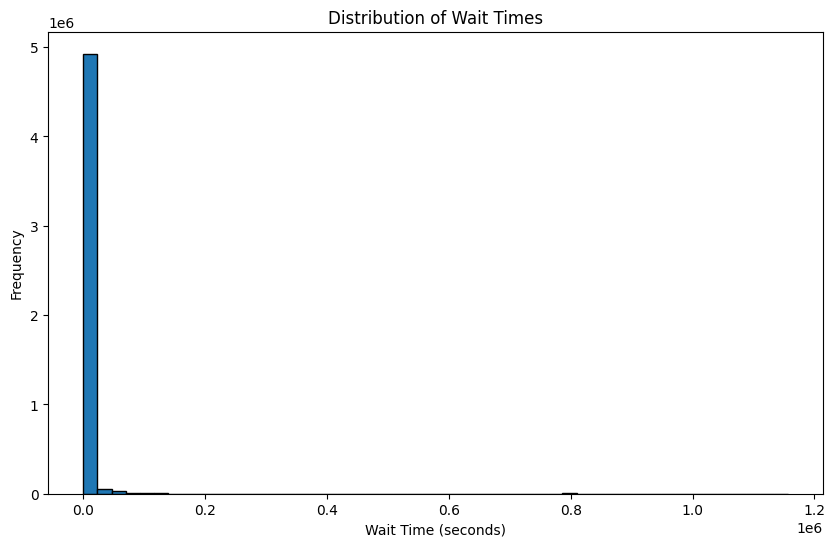

In [10]:
# Plot distribution of wait times
plt.figure(figsize=(10, 6))
plt.hist(txs['waittime'], bins=50, edgecolor='black')
plt.title('Distribution of Wait Times')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Frequency')
plt.show()

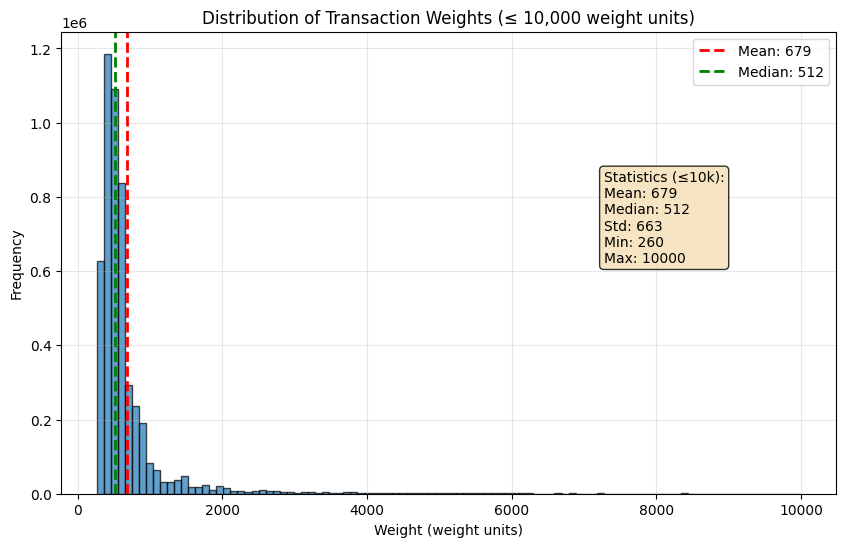

Weight Analysis:
  Total transactions: 5,034,861
  Transactions ≤ 10,000 weight units: 4,999,089 (99.29%)
  Transactions > 10,000 weight units: 35,772 (0.71%)
  Mean weight (≤10k): 678.74 weight units
  Median weight (≤10k): 512.00 weight units
  Standard deviation (≤10k): 663.06
  Min weight (≤10k): 260
  Max weight (≤10k): 10000
  25th percentile (≤10k): 452
  75th percentile (≤10k): 656


In [11]:
# Plot the distribution of transaction weights with detailed analysis
plt.figure(figsize=(10, 6))

# Filter weights to show only up to 10,000 weight units for better visualization
weight_filtered = txs['weight'][txs['weight'] <= 10000]

# Create histogram with more bins for better detail
n, bins, patches = plt.hist(weight_filtered, bins=100, edgecolor='black', alpha=0.7)

# Add statistics to the plot (using filtered data for display)
weight_mean = weight_filtered.mean()
weight_median = weight_filtered.median()
weight_std = weight_filtered.std()

# Add vertical lines for mean and median
plt.axvline(weight_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {weight_mean:.0f}')
plt.axvline(weight_median, color='green', linestyle='--', linewidth=2, label=f'Median: {weight_median:.0f}')

plt.title('Distribution of Transaction Weights (≤ 10,000 weight units)')
plt.xlabel('Weight (weight units)')
plt.ylabel('Frequency')
plt.legend()

# Add text box with statistics
stats_text = f'Statistics (≤10k):\nMean: {weight_mean:.0f}\nMedian: {weight_median:.0f}\nStd: {weight_std:.0f}\nMin: {weight_filtered.min():.0f}\nMax: {weight_filtered.max():.0f}'
plt.text(0.7, 0.7, stats_text, transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

plt.grid(True, alpha=0.3)
plt.show()

# Print additional weight analysis
print(f"Weight Analysis:")
print(f"  Total transactions: {len(txs):,}")
print(f"  Transactions ≤ 10,000 weight units: {len(weight_filtered):,} ({len(weight_filtered)/len(txs)*100:.2f}%)")
print(f"  Transactions > 10,000 weight units: {(txs['weight'] > 10000).sum():,} ({(txs['weight'] > 10000).sum()/len(txs)*100:.2f}%)")
print(f"  Mean weight (≤10k): {weight_mean:.2f} weight units")
print(f"  Median weight (≤10k): {weight_median:.2f} weight units")
print(f"  Standard deviation (≤10k): {weight_std:.2f}")
print(f"  Min weight (≤10k): {weight_filtered.min():.0f}")
print(f"  Max weight (≤10k): {weight_filtered.max():.0f}")
print(f"  25th percentile (≤10k): {weight_filtered.quantile(0.25):.0f}")
print(f"  75th percentile (≤10k): {weight_filtered.quantile(0.75):.0f}")

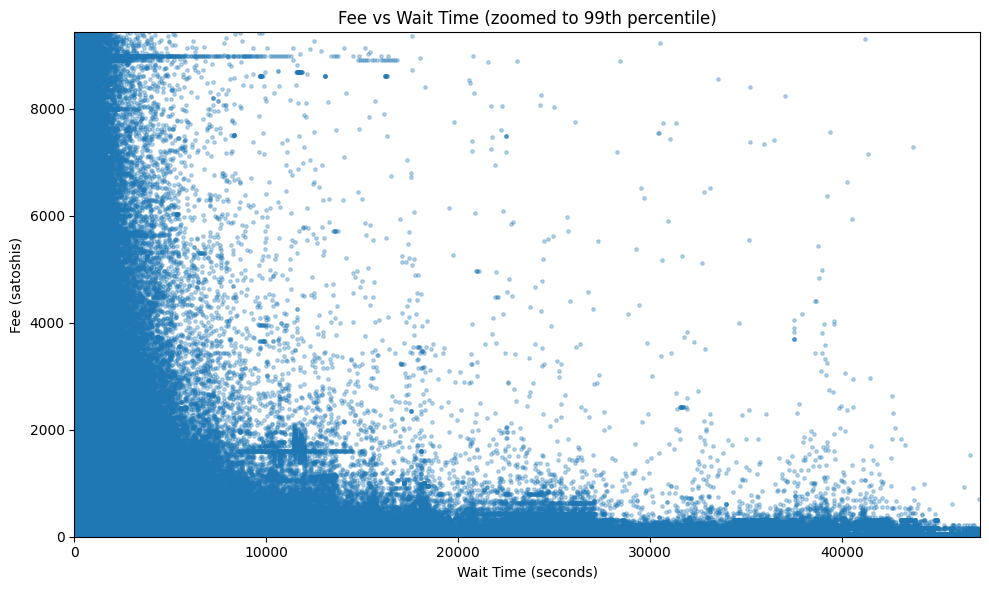

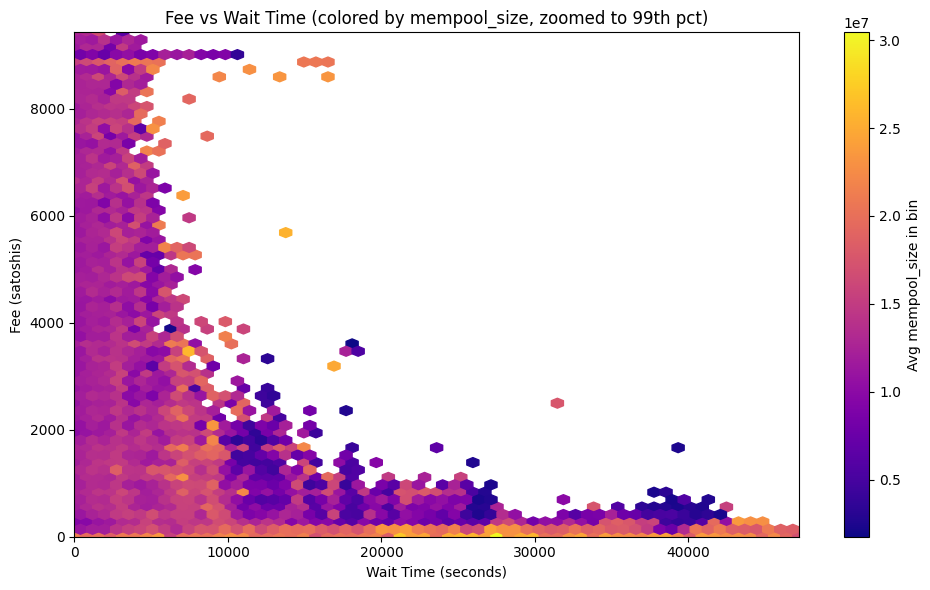

In [12]:
# Plot txs Fee vs Waittime (zoomed near origin)
wt_cap = txs['waittime'].quantile(0.99)
fee_cap = txs['absolute_fee'].quantile(0.99)
mask = (txs['waittime'] <= wt_cap) & (txs['absolute_fee'] <= fee_cap)

plt.figure(figsize=(10, 6))
plt.scatter(txs.loc[mask, 'waittime'], txs.loc[mask, 'absolute_fee'], alpha=0.3, s=6)
plt.title('Fee vs Wait Time (zoomed to 99th percentile)')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Fee (satoshis)')
plt.xlim(0, wt_cap)
plt.ylim(0, fee_cap)
plt.tight_layout()
plt.show()

# Heatmap-style view: hexbin colored by average mempool_size (zoomed)
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    txs.loc[mask, 'waittime'],
    txs.loc[mask, 'absolute_fee'],
    C=txs.loc[mask, 'mempool_size'],
    gridsize=60,
    reduce_C_function=np.mean,
    cmap='plasma',
    mincnt=5,
)
plt.title('Fee vs Wait Time (colored by mempool_size, zoomed to 99th pct)')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Fee (satoshis)')
plt.xlim(0, wt_cap)
plt.ylim(0, fee_cap)
cbar = plt.colorbar(hb)
cbar.set_label('Avg mempool_size in bin')
plt.tight_layout()
plt.show()

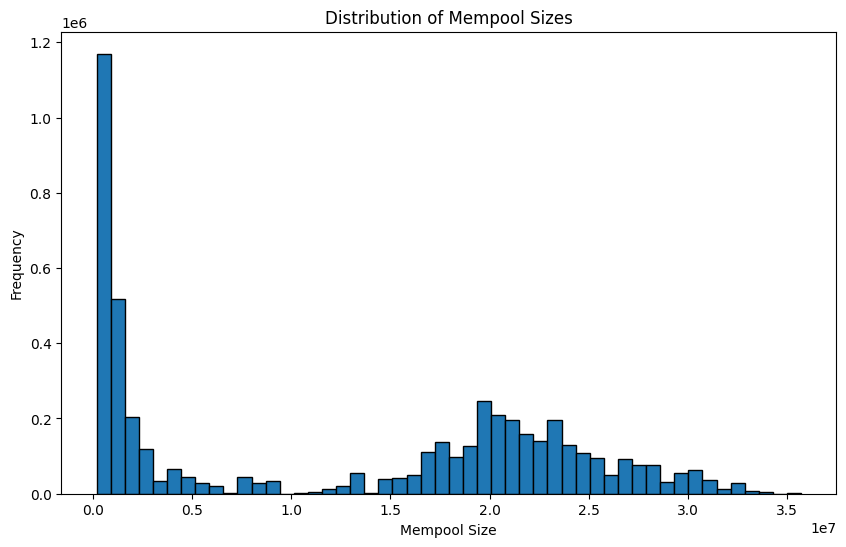

In [13]:
# Plot the distribution of mempool sizes
plt.figure(figsize=(10, 6))
plt.hist(txs['mempool_size'], bins=50, edgecolor='black')
plt.title('Distribution of Mempool Sizes')
plt.xlabel('Mempool Size')
plt.ylabel('Frequency')
plt.show()

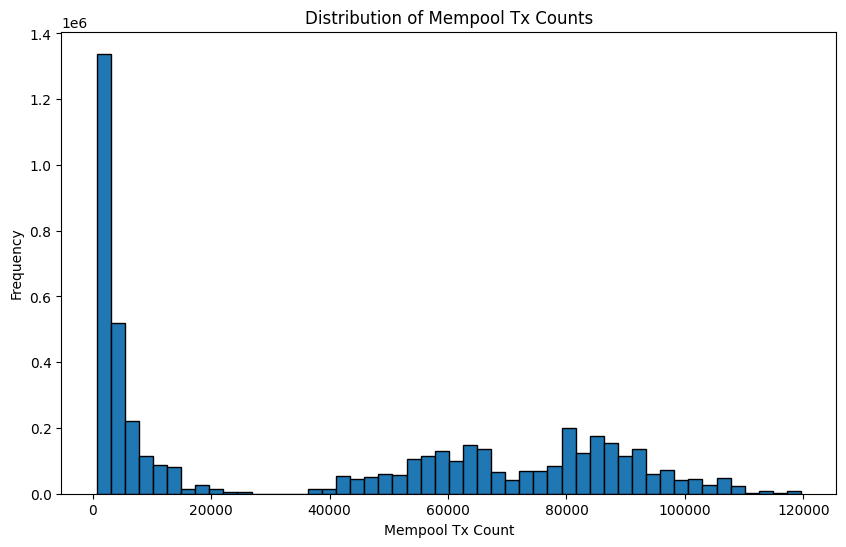

In [14]:
# Plot mempool tx count
plt.figure(figsize=(10, 6))
plt.hist(txs['mempool_tx_count'], bins=50, edgecolor='black')
plt.title('Distribution of Mempool Tx Counts')
plt.xlabel('Mempool Tx Count')
plt.ylabel('Frequency')
plt.show()


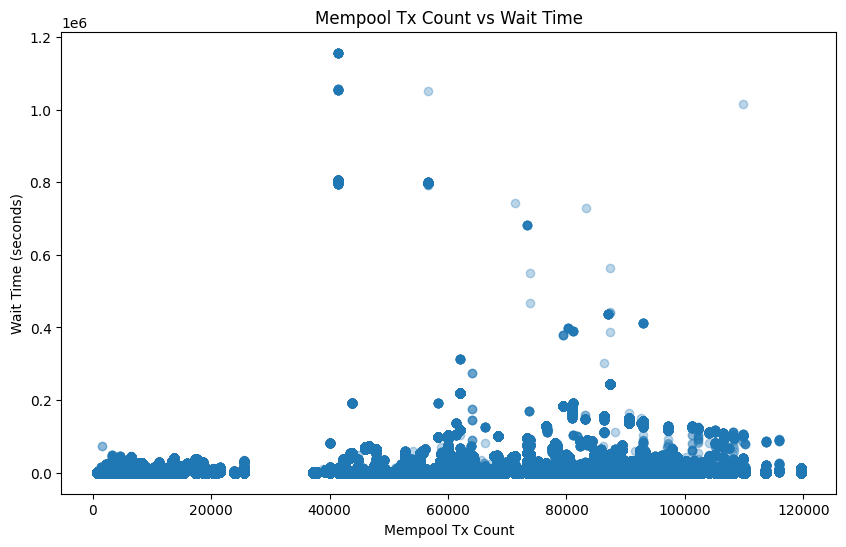

In [15]:
# Plot mempool size vs waittime
plt.figure(figsize=(10, 6))
plt.scatter(txs['mempool_tx_count'], txs['waittime'], alpha=0.3)
plt.xlabel('Mempool Tx Count')
plt.ylabel('Wait Time (seconds)')
plt.title('Mempool Tx Count vs Wait Time')
plt.show()

Train R² = 0.9866
Test R² = 0.9725


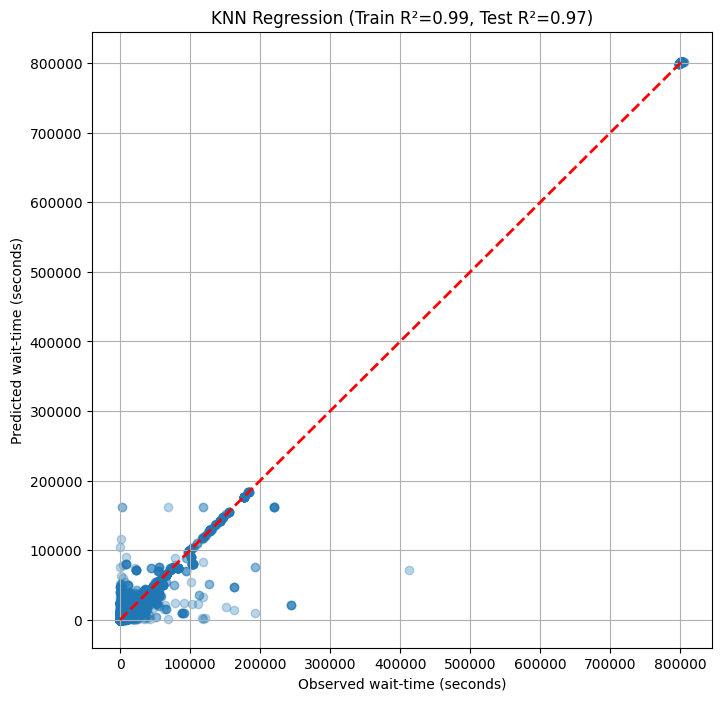

In [16]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

#Subsample to 100k rows
txs_copy = txs.copy().sample(100000, random_state=42)

# Standardize features since they're on very different scales
# Remove NaNs and ensure X and y have matching (non-NaN) rows
cols = ['mempool_tx_count', 'mempool_size', 'absolute_fee', 'waittime']
df_clean = txs_copy[cols].dropna()
X = df_clean[['mempool_tx_count', 'mempool_size', 'absolute_fee']]
y = df_clean['waittime']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Fit KNN regressor
knn = KNeighborsRegressor(n_neighbors=50, weights='distance')
knn.fit(X_train, y_train)

# Calculate R² scores
train_r2 = knn.score(X_train, y_train)
test_r2 = knn.score(X_test, y_test)
print(f"Train R² = {train_r2:.4f}")
print(f"Test R² = {test_r2:.4f}")

# Plot observed vs predicted
y_pred = knn.predict(X_scaled)
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Observed wait-time (seconds)')
plt.ylabel('Predicted wait-time (seconds)')
plt.title(f'KNN Regression (Train R²={train_r2:.2f}, Test R²={test_r2:.2f})')
plt.grid(True)
plt.show()

Test MSE: 68887896.0000


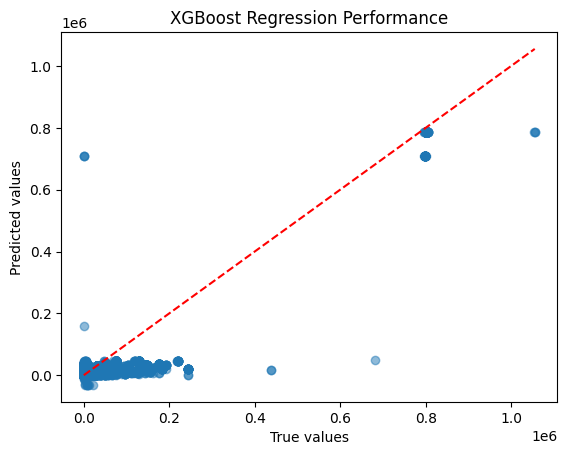

In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
#Subsample to 1m rows
txs_copy = txs.copy().sample(1000000, random_state=42)
df_clean = txs_copy[cols].dropna()
X = df_clean[['mempool_tx_count', 'mempool_size', 'absolute_fee']]
y = df_clean['waittime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("XGBoost Regression Performance")
plt.show()


Train R² = 0.0006
Test R² = 0.0006


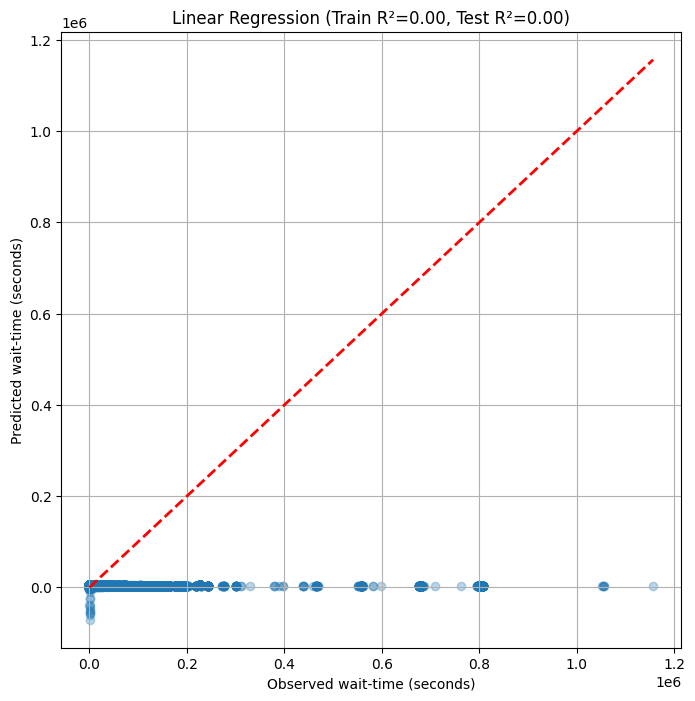

In [14]:
scaler = StandardScaler()
#sample 1m rows
txs_copy = txs.copy().sample(1000000, random_state=42)
df_clean = txs_copy[cols].dropna()
X = df_clean[['mempool_size', 'absolute_fee']]
X_scaled = scaler.fit_transform(X)
y = df_clean['waittime']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model = LinearRegression().fit(X_train, y_train)

# Calculate R² scores
train_r2 = model.score(X_train, y_train)
test_r2 = model.score(X_test, y_test)
print(f"Train R² = {train_r2:.4f}")
print(f"Test R² = {test_r2:.4f}")

# Plot observed vs predicted
y_pred = model.predict(X_scaled)
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Observed wait-time (seconds)')
plt.ylabel('Predicted wait-time (seconds)')
plt.title(f'Linear Regression (Train R²={train_r2:.2f}, Test R²={test_r2:.2f})')
plt.grid(True)
plt.show()

Test MSE: 101992200.3539
Test R^2: 0.8927


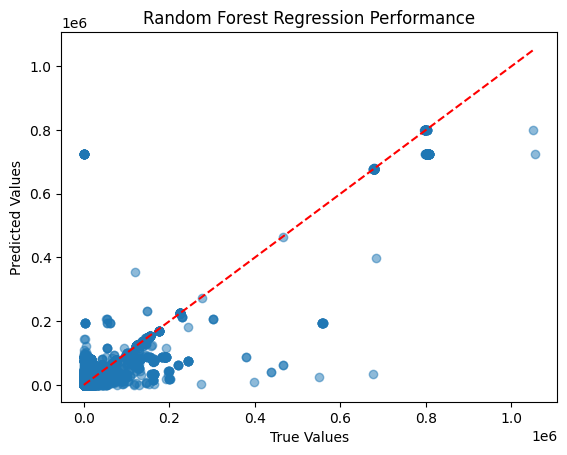

In [15]:
from sklearn.ensemble import RandomForestRegressor

#sample 1m rows
txs_copy = txs.copy().sample(1000000, random_state=42)
df_clean = txs_copy[cols].dropna()
X = df_clean[['mempool_tx_count', 'mempool_size', 'absolute_fee']]
y = df_clean['waittime']
# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and train Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 4. Predict
y_pred = model.predict(X_test)

# 5. Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R^2: {r2:.4f}")

# 6. Optional: Plot predicted vs true
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regression Performance")
plt.show()

# RESPEND ANALYSIS

In [18]:
# Basic respend stats using min_respend_blocks
has_respend = txs['min_respend_blocks'].notna()
respend_count = has_respend.sum()
respend_rate = has_respend.mean()

print(f"Transactions with respend: {respend_count:,} ({respend_rate:.1%})")
print(f"Transactions without respend: {(~has_respend).sum():,} ({(~has_respend).mean():.1%})")


Transactions with respend: 5,034,861 (100.0%)
Transactions without respend: 0 (0.0%)


In [ ]:
# Use min_respend_blocks directly (measured in blocks, not time)
# min_respend_blocks is the number of blocks between tx found and when inputs were respent
blocks_to_respend = txs['min_respend_blocks']


# Stats for respent transactions only
respent_txs = blocks_to_respend[has_respend]
print(f"Blocks to respend stats:")
print(f"  Mean: {respent_txs.mean():.2f} blocks")
print(f"  Median: {respent_txs.median():.1f} blocks")
print(f"  Min: {respent_txs.min():.0f} blocks")
print(f"  Max: {respent_txs.max():.0f} blocks")
print(f"  Std: {respent_txs.std():.2f} blocks")


Blocks to respend stats:
  Mean: 2932.85 blocks
  Median: 3.0 blocks
  Min: 0 blocks
  Max: 790470 blocks
  Std: 21309.69 blocks


In [20]:
# Compare wait times: respent vs not respent
waittime_respent = txs.loc[has_respend, 'waittime']
waittime_no_respend = txs.loc[~has_respend, 'waittime']

print(f"Wait time comparison (minutes):")
print(f"  Respent txs - Mean: {waittime_respent.mean()/60:.1f}, Median: {waittime_respent.median()/60:.1f}")
print(f"  No respend  - Mean: {waittime_no_respend.mean()/60:.1f}, Median: {waittime_no_respend.median()/60:.1f}")
print(f"  Difference  - Mean: {(waittime_respent.mean() - waittime_no_respend.mean())/60:.1f} min")


Wait time comparison (minutes):
  Respent txs - Mean: 55.0, Median: 8.8
  No respend  - Mean: nan, Median: nan
  Difference  - Mean: nan min


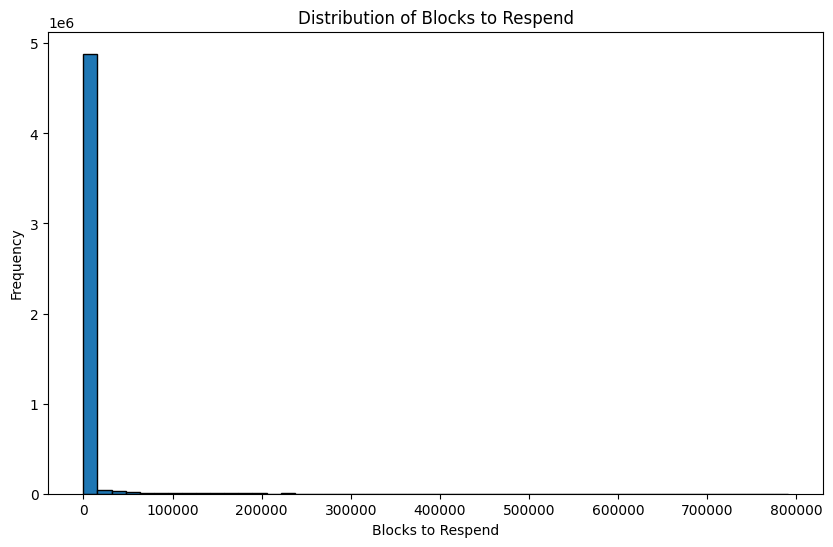

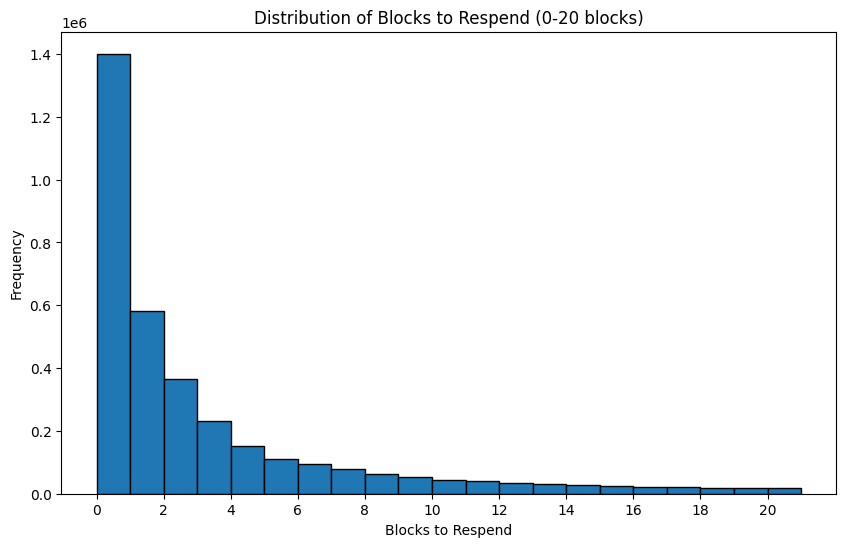

In [21]:
# Plot distribution of blocks to respend
plt.figure(figsize=(10, 6))
plt.hist(respent_txs.dropna(), bins=50, edgecolor='black')
plt.title('Distribution of Blocks to Respend')
plt.xlabel('Blocks to Respend')
plt.ylabel('Frequency')
plt.show()

# Also show a zoomed view for the common case (0-20 blocks)
plt.figure(figsize=(10, 6))
respent_filtered = respent_txs[respent_txs <= 20]
plt.hist(respent_filtered.dropna(), bins=21, edgecolor='black', range=(0, 21))
plt.title('Distribution of Blocks to Respend (0-20 blocks)')
plt.xlabel('Blocks to Respend')
plt.ylabel('Frequency')
plt.xticks(range(0, 21, 2))
plt.show()


  → Copying dataframe...
  ✓ Copy complete (3.6s)
  → Calculating respend delay (in blocks)...
  → Calculating time_cost (1 / blocks)...
  ✓ Time_cost calculated (4.7s)

Detailed time_cost distribution statistics (block-based):
  Count:   5,034,861
  Mean:    278168.549741
  Median:  0.333333
  Std Dev: 448096.699846
  Min:     1.265070e-06
  Max:     1.000000e+06
  1st percentile: 0.000012
  99th percentile: 1000000.000000


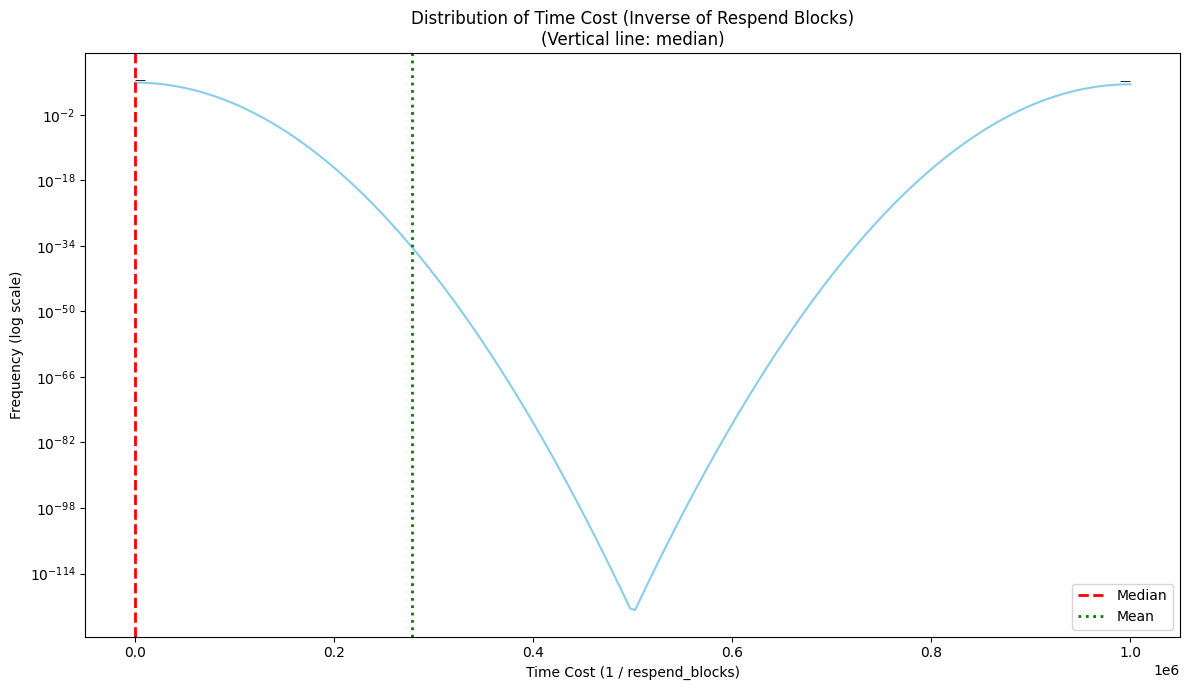

In [22]:
import time as time_module
import seaborn as sns

# Time cost proxy calculation
# Calculate time_cost from min_respend_blocks data (now measured in blocks, not time)
start_time = time_module.time()
print("  → Copying dataframe...")
txs_test = txs.copy()
print(f"  ✓ Copy complete ({time_module.time() - start_time:.1f}s)")

# Use min_respend_blocks as respend delay (measured in blocks)
print("  → Calculating respend delay (in blocks)...")
txs_test['respend_delay'] = txs_test['min_respend_blocks']

# Filter valid respends (delay >= 0 and not NaN)
valid_respend = (txs_test['respend_delay'] >= 0) & txs_test['respend_delay'].notna()

# Calculate time_cost (inverse of delay with epsilon to avoid division by zero)
# Higher time_cost = fewer blocks to respend = more impatient user
print("  → Calculating time_cost (1 / blocks)...")
txs_test['time_cost'] = np.nan
txs_test.loc[valid_respend, 'time_cost'] = 1 / (txs_test.loc[valid_respend, 'respend_delay'] + 1e-6)
print(f"  ✓ Time_cost calculated ({time_module.time() - start_time:.1f}s)")

# Extract non-null time_cost values for analysis
time_cost_values = txs_test['time_cost'].dropna()

# Summary statistics
print("\nDetailed time_cost distribution statistics (block-based):")
print(f"  Count:   {len(time_cost_values):,}")
print(f"  Mean:    {time_cost_values.mean():.6f}")
print(f"  Median:  {time_cost_values.median():.6f}")
print(f"  Std Dev: {time_cost_values.std():.6f}")
print(f"  Min:     {time_cost_values.min():.6e}")
print(f"  Max:     {time_cost_values.max():.6e}")
print(f"  1st percentile: {time_cost_values.quantile(0.01):.6f}")
print(f"  99th percentile: {time_cost_values.quantile(0.99):.6f}")

plt.figure(figsize=(12, 7))
# Plot using a density-aware histogram for a better sense of distribution
sns.histplot(time_cost_values, bins=100, kde=True, log_scale=(False, True), color='skyblue', edgecolor='black', alpha=0.75)
plt.title('Distribution of Time Cost (Inverse of Respend Blocks)\n(Vertical line: median)')
plt.xlabel('Time Cost (1 / respend_blocks)')
plt.ylabel('Frequency (log scale)')
plt.axvline(time_cost_values.median(), color='red', linestyle='dashed', linewidth=2, label="Median")
plt.axvline(time_cost_values.mean(), color='green', linestyle='dotted', linewidth=2, label="Mean")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Visualize respend delay (in blocks) for transactions with/without CPFP child transactions
import numpy as np
import matplotlib.pyplot as plt

if 'txs_test' not in globals():
    txs_test = txs.copy()
    txs_test['respend_delay'] = txs_test['min_respend_blocks']


plot_df = txs_test[['respend_delay', 'child_txid']].copy()
plot_df['has_child'] = plot_df['child_txid'].notna()
plot_df['respend_delay'] = plot_df['respend_delay'].fillna(0)

cpf_total = plot_df['has_child'].sum()
cpf_zero = (plot_df.loc[plot_df['has_child'], 'respend_delay'] == 0).sum()
cpf_positive = (plot_df.loc[plot_df['has_child'], 'respend_delay'] > 0).sum()
share_zero = (cpf_zero / cpf_total * 100) if cpf_total else 0.0
share_positive = (cpf_positive / cpf_total * 100) if cpf_total else 0.0
print(f"CPFP child txs with zero respend blocks: {cpf_zero} / {cpf_total} ({share_zero:.2f}%)")
print(f"CPFP child txs with positive respend blocks: {cpf_positive} / {cpf_total} ({share_positive:.2f}%)")

plot_df['log_delay'] = plot_df['respend_delay'].replace(0, 0.1)  # Use 0.1 for log scale
plot_df['log_delay'] = np.log10(plot_df['log_delay'])

plt.figure(figsize=(12, 6))
# Left subplot: scatter with jitter
plt.subplot(1, 2, 1)
sampled = (
    plot_df.groupby('has_child', group_keys=False)
    .apply(lambda x: x.sample(n=min(len(x), 20000), random_state=42) if len(x) > 0 else x, include_groups=False)
    .reset_index(drop=True)
)
# Re-add has_child column after apply
sampled['has_child'] = plot_df.loc[sampled.index, 'has_child'].values if len(sampled) == len(plot_df.loc[sampled.index]) else sampled['has_child']
y_jitter = np.random.uniform(-0.08, 0.08, size=len(sampled))
y_positions = sampled['has_child'].astype(int).values + y_jitter
colors = np.where(sampled['has_child'], '#ff7f0e', '#1f77b4')
plt.scatter(sampled['respend_delay'], y_positions, s=10, alpha=0.3, c=colors, edgecolors='none')
plt.yticks([0, 1], ['No CPFP child', 'Has CPFP child'])
plt.xlabel('Respend delay (blocks)')
plt.title('Respend delay (blocks) and CPFP presence')
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
p99 = sampled['respend_delay'].quantile(0.99) if not sampled.empty else 1
if p99 > 0:
    plt.xlim(-0.5, min(p99, 50))  # Cap at 50 blocks for visualization
plt.grid(axis='x', alpha=0.3)

# Right subplot: distribution of respend delay (log scale)
plt.subplot(1, 2, 2)
bins = np.linspace(plot_df['log_delay'].min(), plot_df['log_delay'].max(), 60)
for has_child, label, color in [(True, 'Has CPFP child', '#ff7f0e'), (False, 'No CPFP child', '#1f77b4')]:
    mask = plot_df['has_child'] == has_child
    plt.hist(plot_df.loc[mask, 'log_delay'], bins=bins, alpha=0.6, label=label, color=color)
plt.xlabel('log10(respend delay in blocks)')
plt.ylabel('Count')
plt.title('Distribution of respend delays in blocks (log scale)')
plt.legend()
plt.tight_layout()
plt.show()


AttributeError: Can only use .dt accessor with datetimelike values

KeyError: "['epoch'] not in index"

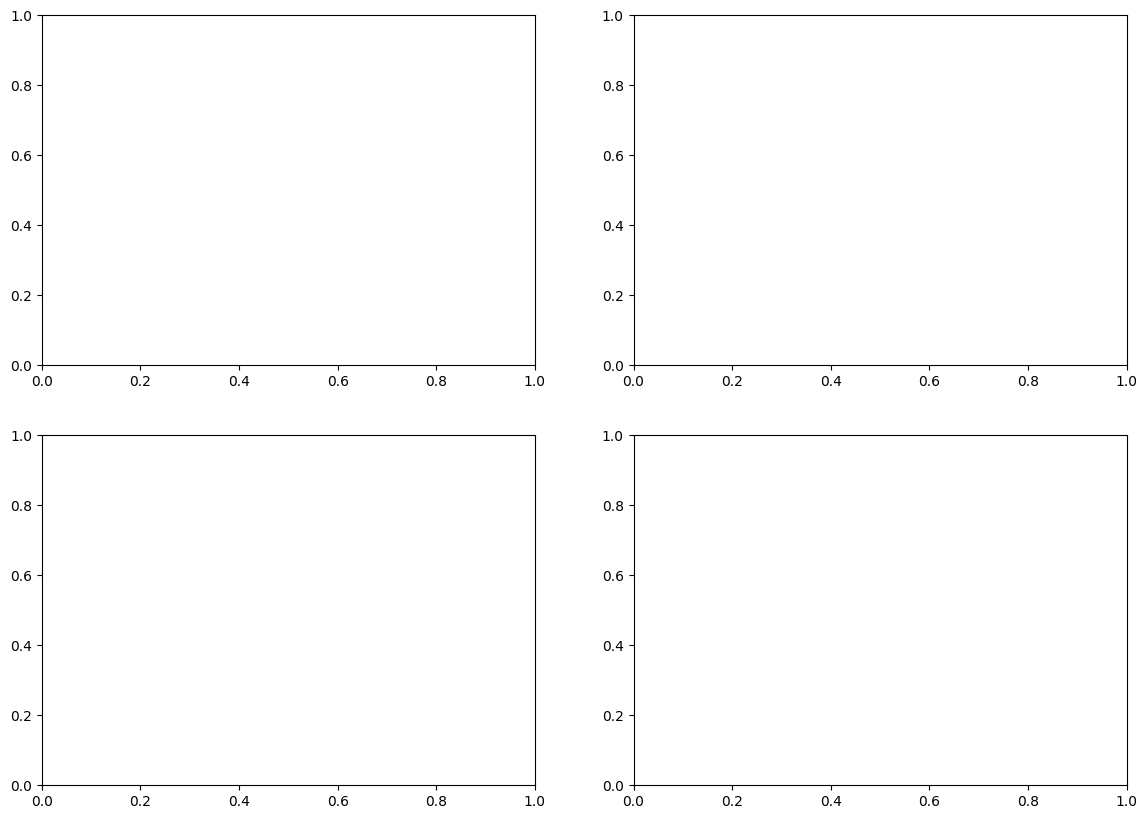

In [7]:
# Visualize: Congestion (rho_t) vs Mempool Size comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Congestion over time
epoch_rho = txs_test[['epoch', 'mempool_size']].drop_duplicates().sort_values('epoch')
axes[0, 0].plot(epoch_rho['epoch'], epoch_rho['mempool_size'], marker='o', markersize=2, linewidth=1, alpha=0.7)
axes[0, 0].set_title('Mempool Congestion (ρ_t) Over Epochs', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Congestion (transactions)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Mempool size over time (for comparison)
time_sorted = txs_test.sort_values('found_at')[['found_at', 'mempool_size']].iloc[::1000]  # Sample
axes[0, 1].plot(time_sorted['found_at'], time_sorted['mempool_size'], linewidth=1, alpha=0.7, color='orange')
axes[0, 1].set_title('Mempool Size Over Time (Raw)', fontweight='bold')
axes[0, 1].set_xlabel('Unix Timestamp')
axes[0, 1].set_ylabel('Mempool Size (bytes)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Congestion vs Waittime
sample = txs_test[['mempool_size', 'waittime']].dropna().sample(min(10000, len(txs_test)), random_state=42)
axes[1, 0].scatter(sample['mempool_size'], sample['waittime']/60, alpha=0.3, s=10)
axes[1, 0].set_title('Congestion vs Wait Time', fontweight='bold')
axes[1, 0].set_xlabel('Congestion (ρ_t)')
axes[1, 0].set_ylabel('Wait Time (minutes)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Mempool Size vs Waittime (for comparison)
sample2 = txs_test[['mempool_size', 'waittime']].dropna().sample(min(10000, len(txs_test)), random_state=42)
axes[1, 1].scatter(sample2['mempool_size'], sample2['waittime']/60, alpha=0.3, s=10, color='orange')
axes[1, 1].set_title('Mempool Size vs Wait Time', fontweight='bold')
axes[1, 1].set_xlabel('Mempool Size (bytes)')
axes[1, 1].set_ylabel('Wait Time (minutes)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


DATA GAP ANALYSIS



Time difference statistics (seconds):
  Mean:   0.39
  Median: 0.00
  Std:    380.81
  95th percentile: 1.00
  99th percentile: 2.00

GAPS IDENTIFIED (threshold: 1.0 hours)

Total gaps found: 3

Gap #    Start                     End                       Duration (hours)   Duration (days)
--------------------------------------------------------------------------------------------------------------
1        2025-08-22 17:49:30       2025-09-05 10:41:10       328.86             13.70          
2        2025-09-12 14:14:42       2025-09-22 13:56:29       239.70             9.99           
3        2025-09-24 12:56:42       2025-09-26 10:20:25       45.40              1.89           

GAP SUMMARY STATISTICS
Total data collection gaps: 3
Total time lost to gaps:    613.95 hours (25.58 days)
Average gap duration:       204.65 hours (8.53 days)
Longest gap:                328.86 hours (13.70 days)
Shortest gap:               45.40 hours (1.89 days)

DATA COMPLETENESS
Total time span:      6

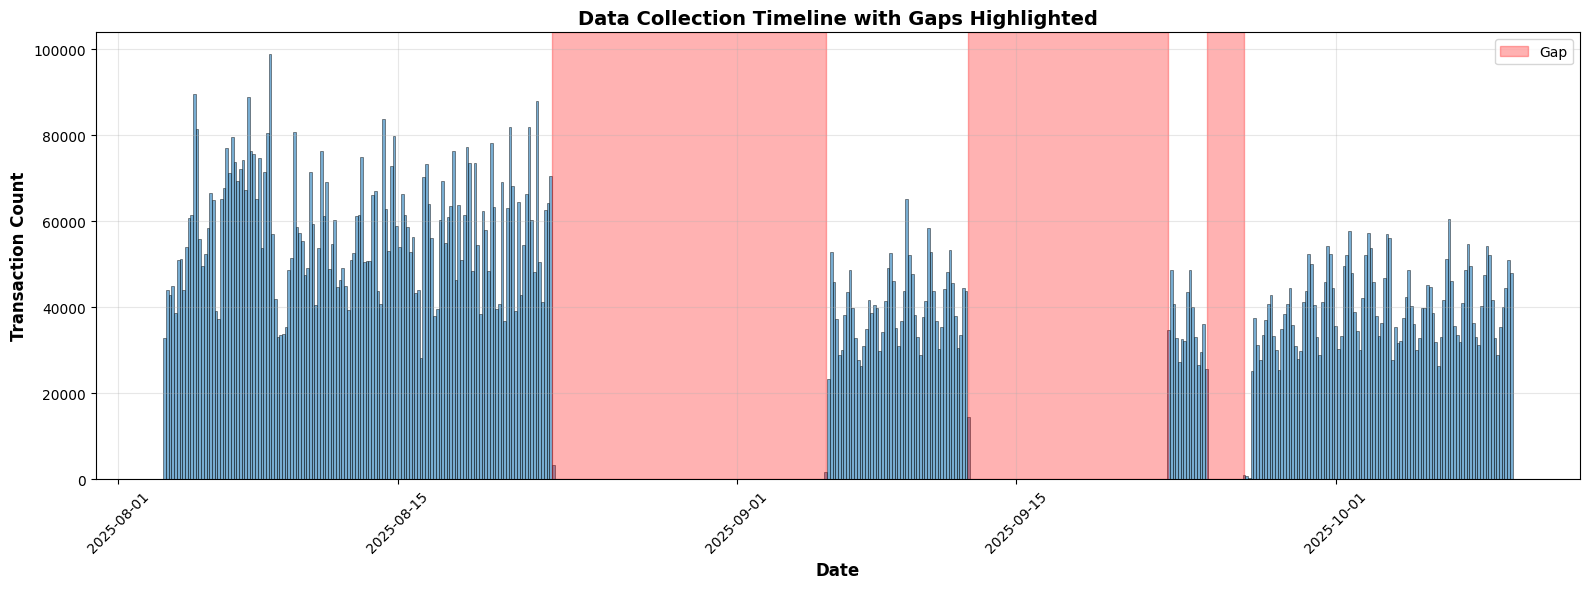

In [24]:
# DATA GAP ANALYSIS
# Identify gaps in data collection

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

print("=" * 80)
print("DATA GAP ANALYSIS")
print("=" * 80)

# Ensure we have a numeric timestamp column
if 'found_at_ts' not in txs_with_congestion.columns:
    if txs_with_congestion['found_at'].dtype == 'object' or pd.api.types.is_datetime64_any_dtype(txs_with_congestion['found_at']):
        txs_with_congestion['found_at_ts'] = pd.to_datetime(txs_with_congestion['found_at']).astype('int64') // 10**9
    else:
        txs_with_congestion['found_at_ts'] = txs_with_congestion['found_at']

# Sort by found_at_ts to analyze temporal gaps
df_sorted = txs_with_congestion.sort_values('found_at_ts').copy()

# Calculate time differences between consecutive transactions (using numeric timestamps)
df_sorted['time_diff'] = df_sorted['found_at_ts'].diff()

# Get statistics on typical intervals
print(f"\nTime difference statistics (seconds):")
print(f"  Mean:   {df_sorted['time_diff'].mean():.2f}")
print(f"  Median: {df_sorted['time_diff'].median():.2f}")
print(f"  Std:    {df_sorted['time_diff'].std():.2f}")
print(f"  95th percentile: {df_sorted['time_diff'].quantile(0.95):.2f}")
print(f"  99th percentile: {df_sorted['time_diff'].quantile(0.99):.2f}")

# Define a gap as any interval > 1 hour (3600 seconds)
# This is well above the 99th percentile of normal intervals
GAP_THRESHOLD_SECONDS = 3600  # 1 hour
GAP_THRESHOLD_HOURS = GAP_THRESHOLD_SECONDS / 3600

# Find all gaps
gaps = df_sorted[df_sorted['time_diff'] > GAP_THRESHOLD_SECONDS].copy()

print(f"\n" + "=" * 80)
print(f"GAPS IDENTIFIED (threshold: {GAP_THRESHOLD_HOURS:.1f} hours)")
print("=" * 80)
print(f"\nTotal gaps found: {len(gaps)}")

if len(gaps) > 0:
    # For each gap, find the start and end times
    gap_details = []
    
    for idx, row in gaps.iterrows():
        gap_duration_hours = row['time_diff'] / 3600
        gap_duration_days = gap_duration_hours / 24
        
        # Find the index of the previous transaction
        prev_idx = df_sorted.index[df_sorted.index.get_loc(idx) - 1]
        prev_timestamp = df_sorted.loc[prev_idx, 'found_at_ts']
        curr_timestamp = row['found_at_ts']
        
        gap_details.append({
            'gap_start': prev_timestamp,
            'gap_end': curr_timestamp,
            'duration_hours': gap_duration_hours,
            'duration_days': gap_duration_days,
            'gap_start_datetime': pd.to_datetime(prev_timestamp, unit='s'),
            'gap_end_datetime': pd.to_datetime(curr_timestamp, unit='s')
        })
    
    gap_df = pd.DataFrame(gap_details)
    
    print(f"\n{'Gap #':<8} {'Start':<25} {'End':<25} {'Duration (hours)':<18} {'Duration (days)':<15}")
    print("-" * 110)
    
    for i, row in gap_df.iterrows():
        print(f"{i+1:<8} {str(row['gap_start_datetime']):<25} {str(row['gap_end_datetime']):<25} "
              f"{row['duration_hours']:<18.2f} {row['duration_days']:<15.2f}")
    
    # Summary statistics
    print(f"\n" + "=" * 80)
    print("GAP SUMMARY STATISTICS")
    print("=" * 80)
    print(f"Total data collection gaps: {len(gap_df)}")
    print(f"Total time lost to gaps:    {gap_df['duration_hours'].sum():.2f} hours ({gap_df['duration_days'].sum():.2f} days)")
    print(f"Average gap duration:       {gap_df['duration_hours'].mean():.2f} hours ({gap_df['duration_days'].mean():.2f} days)")
    print(f"Longest gap:                {gap_df['duration_hours'].max():.2f} hours ({gap_df['duration_days'].max():.2f} days)")
    print(f"Shortest gap:               {gap_df['duration_hours'].min():.2f} hours ({gap_df['duration_days'].min():.2f} days)")
    
    # Calculate data completeness
    total_time_span = df_sorted['found_at_ts'].max() - df_sorted['found_at_ts'].min()
    total_gap_time = gap_df['duration_hours'].sum() * 3600  # Convert back to seconds
    data_completeness = (total_time_span - total_gap_time) / total_time_span * 100
    
    print(f"\n" + "=" * 80)
    print("DATA COMPLETENESS")
    print("=" * 80)
    print(f"Total time span:      {total_time_span / 86400:.2f} days")
    print(f"Time with data:       {(total_time_span - total_gap_time) / 86400:.2f} days")
    print(f"Time in gaps:         {total_gap_time / 86400:.2f} days")
    print(f"Data completeness:    {data_completeness:.2f}%")
    
    # Check if gaps are consistent across all metrics
    print(f"\n" + "=" * 80)
    print("GAP CONSISTENCY CHECK")
    print("=" * 80)
    print("Checking if gaps affect all data columns equally...")
    
    # Convert txs['found_at'] to timestamp for comparison if needed
    if txs['found_at'].dtype == 'object' or pd.api.types.is_datetime64_any_dtype(txs['found_at']):
        txs_found_at_ts = pd.to_datetime(txs['found_at']).astype('int64') // 10**9
    else:
        txs_found_at_ts = txs['found_at']
    
    # For each gap period, check if we have ANY data
    for i, row in gap_df.iterrows():
        gap_start = row['gap_start']
        gap_end = row['gap_end']
        
        # Check if any transactions exist in this gap period
        txs_in_gap = txs[(txs_found_at_ts > gap_start) & (txs_found_at_ts < gap_end)]
        
        print(f"\nGap #{i+1} ({row['gap_start_datetime']} to {row['gap_end_datetime']}):")
        print(f"  Transactions found in gap: {len(txs_in_gap)}")
        
        if len(txs_in_gap) > 0:
            print(f"  ⚠️  WARNING: This gap is NOT consistent across all data!")
            print(f"  Some transactions exist but were not included in analysis.")
        else:
            print(f"  ✓ Gap is consistent - no data collected during this period")
    
    # Visualize gaps on timeline
    print(f"\n" + "=" * 80)
    print("VISUALIZING GAPS")
    print("=" * 80)
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot all timestamps as a histogram
    timestamps = pd.to_datetime(df_sorted['found_at_ts'], unit='s')
    ax.hist(timestamps, bins=500, alpha=0.6, edgecolor='black', linewidth=0.5)
    
    # Highlight gap periods with red vertical spans
    for i, row in gap_df.iterrows():
        ax.axvspan(row['gap_start_datetime'], row['gap_end_datetime'], 
                   alpha=0.3, color='red', label='Gap' if i == 0 else '')
    
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Transaction Count', fontsize=12, fontweight='bold')
    ax.set_title('Data Collection Timeline with Gaps Highlighted', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
else:
    print("\n✓ No significant gaps found in data collection!")

print(f"\n" + "=" * 80)

In [5]:
# NFT/Inscription Detection
# Aligned with phase3_fee_model_new_data.ipynb approach

import json

def get_max_output_weight(output_weights_str):
    """Parse output_weights JSON and return max individual output weight"""
    if pd.isna(output_weights_str):
        return 0
    try:
        weights = json.loads(output_weights_str)
        return max(weights) if weights else 0
    except:
        return 0

print("="*60)
print("NFT/INSCRIPTION DETECTION")
print("="*60)

# Check if we have output_weights column for proper NFT detection
if 'output_weights' in txs_with_congestion.columns:
    print("\n✓ Found 'output_weights' column - using individual output weight detection")
    
    # Calculate max individual output weight for each transaction
    print("  Parsing output weights...")
    txs_with_congestion['max_output_weight'] = txs_with_congestion['output_weights'].apply(get_max_output_weight)
    
    print(f"\n  Max individual output weight stats:")
    print(txs_with_congestion['max_output_weight'].describe())
    
    # Check if we have any large individual outputs (NFT/inscriptions would be >1000)
    nft_output_threshold = 1000  # Inscriptions typically >10,000 weight
    has_large_outputs = (txs_with_congestion['max_output_weight'] > nft_output_threshold).any()
    
    if has_large_outputs:
        # Use individual output weight for NFT detection
        print(f"\n✓ Using individual output weights for NFT detection (threshold: {nft_output_threshold})")
        txs_with_congestion['NFT_it'] = (txs_with_congestion['max_output_weight'] > nft_output_threshold).astype(int)
    else:
        # Fallback: use total tx weight (99th percentile) for "large transaction" indicator
        nft_threshold = txs_with_congestion['weight'].quantile(0.99)
        print(f"\n⚠ No large individual outputs found - using total tx weight (threshold: {nft_threshold:.0f})")
        print(f"  Note: This identifies 'large transactions' (batched payments, consolidations), not true NFTs")
        txs_with_congestion['NFT_it'] = (txs_with_congestion['weight'] >= nft_threshold).astype(int)

elif 'weight' in txs_with_congestion.columns:
    # Fallback if output_weights not available
    print("\n⚠ 'output_weights' column not found - falling back to total weight detection")
    weight_99th = txs_with_congestion['weight'].quantile(0.99)
    
    txs_with_congestion['NFT_it'] = (txs_with_congestion['weight'] > weight_99th).astype(int)
    print(f"  Weight threshold (99th percentile): {weight_99th:,.0f}")
    print(f"  Note: This identifies 'large transactions', not true NFTs")

else:
    print("\n⚠ Neither 'output_weights' nor 'weight' columns found")
    txs_with_congestion['NFT_it'] = 0

print(f"\nNFT_it distribution:\n{txs_with_congestion['NFT_it'].value_counts()}")
print(f"\nNFT transactions: {(txs_with_congestion['NFT_it']==1).sum():,} ({(txs_with_congestion['NFT_it']==1).sum()/len(txs_with_congestion)*100:.2f}%)")

NFT/INSCRIPTION DETECTION

✓ Found 'output_weights' column - using individual output weight detection
  Parsing output weights...



  Max individual output weight stats:
count    1.498454e+07
mean     1.488113e+02
std      3.533551e+01
min      4.000000e+01
25%      1.240000e+02
50%      1.360000e+02
75%      1.720000e+02
max      5.840000e+02
Name: max_output_weight, dtype: float64

⚠ No large individual outputs found - using total tx weight (threshold: 6396)
  Note: This identifies 'large transactions' (batched payments, consolidations), not true NFTs

NFT_it distribution:
NFT_it
0    14834599
1      149941
Name: count, dtype: int64

NFT transactions: 149,941 (1.00%)


Filtering data to before first gap: 2025-08-22 17:49:10
Original data size: 14,984,540 transactions
Filtered data size: 14,984,540 transactions
Test MSE (log scale): 1.2757
Test R^2 (log scale): 0.4110

=== FEATURE IMPORTANCE ===
  log_rho_t                : 0.5973
  log_time_cost            : 0.2664
  has_child                : 0.1209
  rbf_flag                 : 0.0103
  NFT_it                   : 0.0052


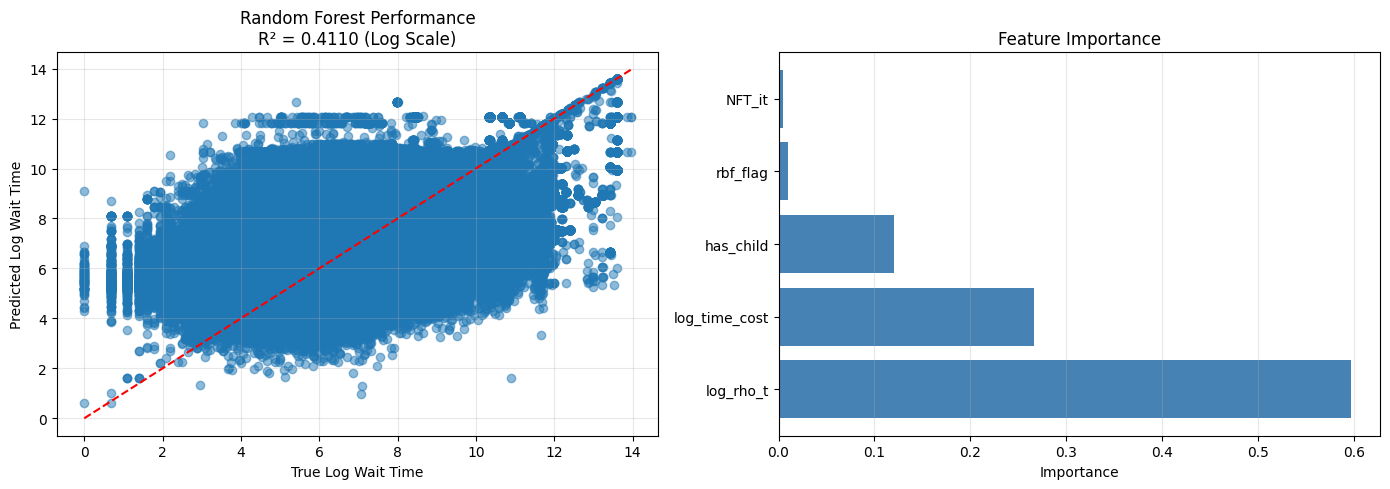

In [6]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

# Ensure we have numeric timestamp column
if 'found_at_ts' not in txs_with_congestion.columns:
    if txs_with_congestion['found_at'].dtype == 'object' or pd.api.types.is_datetime64_any_dtype(txs_with_congestion['found_at']):
        txs_with_congestion['found_at_ts'] = pd.to_datetime(txs_with_congestion['found_at']).astype('int64') // 10**9
    else:
        txs_with_congestion['found_at_ts'] = txs_with_congestion['found_at']

# Filter to only include data from the first continuous chunk (before first gap)
# Gap starts at 2025-08-22 17:49:10
first_gap_start = pd.Timestamp('2025-08-22 17:49:10').timestamp()
print(f"Filtering data to before first gap: {pd.to_datetime(first_gap_start, unit='s')}")
print(f"Original data size: {len(txs_with_congestion):,} transactions")

#txs_with_congestion = txs_with_congestion[txs_with_congestion['found_at_ts'] < first_gap_start].copy()
print(f"Filtered data size: {len(txs_with_congestion):,} transactions")

#txs_with_congestion = txs_with_congestion[txs_with_congestion['respend_delay'] > 0]
txs_with_congestion['has_child'] = txs_with_congestion['child_txid'].notna().astype(int)
txs_with_congestion['rbf_flag'] = txs['rbf_fee_total'].notna().astype(int)

#sample 2m rows (or all if less than 2m)
#sample_size = min(20000000, len(txs_with_congestion))
#txs_copy = txs_with_congestion.copy().sample(sample_size, random_state=42)
df_clean = txs_with_congestion[['mempool_tx_count', 'rho_t', 'time_cost', 'has_child', 'rbf_flag', 'waittime', 'NFT_it']].dropna()

# Log transform features to improve model performance
df_clean['log_mempool_tx_count'] = np.log1p(df_clean['mempool_tx_count'])
df_clean['log_rho_t'] = np.log1p(df_clean['rho_t'])
df_clean['log_time_cost'] = df_clean['time_cost']
# has_child is already binary (0/1), so no log transform needed
df_clean['log_waittime'] = np.log1p(df_clean['waittime'])

valid_idx = df_clean.notna().all(axis=1) & df_clean['waittime'].notna()

df_clean = df_clean[valid_idx]
X = df_clean[['log_rho_t', 'log_time_cost', 'has_child', 'rbf_flag', 'NFT_it']]
y = df_clean['log_waittime']
# 2. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and train Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-2
)
model.fit(X_train, y_train)

# 4. Predict
y_pred = model.predict(X_test)

# 5. Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE (log scale): {mse:.4f}")
print(f"Test R^2 (log scale): {r2:.4f}")

# 6. Feature Importance
feature_names = ['log_rho_t', 'log_time_cost', 'has_child', 'rbf_flag', 'NFT_it']
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(f"\n=== FEATURE IMPORTANCE ===")
for idx, row in feature_importance_df.iterrows():
    print(f"  {row['feature']:25s}: {row['importance']:.4f}")

# 7. Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted vs True (in log scale)
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel("True Log Wait Time")
axes[0].set_ylabel("Predicted Log Wait Time")
axes[0].set_title(f"Random Forest Performance\nR² = {r2:.4f} (Log Scale)")
axes[0].grid(True, alpha=0.3)

# Plot 2: Feature Importance
axes[1].barh(feature_importance_df['feature'], feature_importance_df['importance'], color='steelblue')
axes[1].set_xlabel('Importance')
axes[1].set_title('Feature Importance')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

COMPREHENSIVE MODEL EVALUATION

📊 REGRESSION METRICS (Log Scale):
  R² Score:                    0.4110
  Explained Variance:          0.4110
  Root Mean Squared Error:     1.1295
  Mean Absolute Error:         0.8375
  Median Absolute Error:       0.6348
  Mean Absolute % Error:       inf%

⏱️  METRICS IN ORIGINAL SCALE (seconds):
  RMSE:                        25652.56 seconds (427.54 minutes)
  MAE:                         2499.11 seconds (41.65 minutes)
  Median Absolute Error:       293.43 seconds (4.89 minutes)

📈 ERROR DISTRIBUTION (seconds):
  50th percentile (median):    293.43 seconds (4.89 min)
  75th percentile:             730.12 seconds (12.17 min)
  90th percentile:             2208.33 seconds (36.81 min)
  95th percentile:             5143.80 seconds (85.73 min)
  99th percentile:             30565.82 seconds (509.43 min)

🎯 PREDICTION ACCURACY:
  Within ±1 minute:            12.72%
  Within ±5 minutes:           50.68%
  Within ±10 minutes:          70.35%
  Within ±30

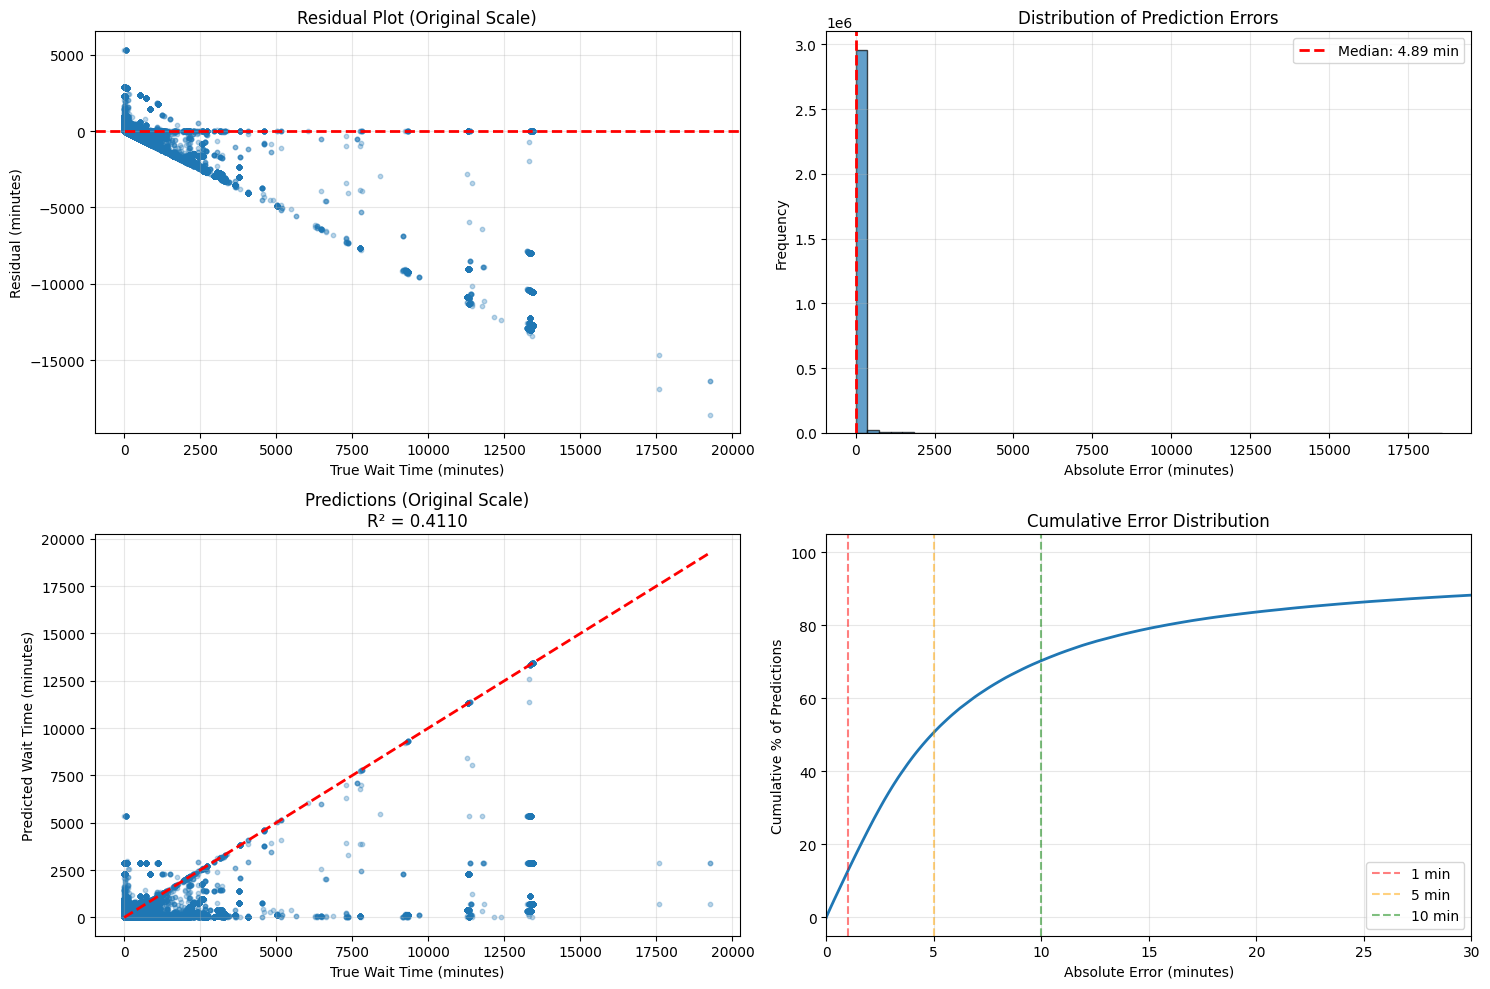

In [7]:
# ADDITIONAL EVALUATION METRICS FOR CURRENT MODEL
# More ways to assess predictive power

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score

print("=" * 80)
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 80)

# Basic metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
explained_var = explained_variance_score(y_test, y_pred)

print(f"\n📊 REGRESSION METRICS (Log Scale):")
print(f"  R² Score:                    {r2:.4f}")
print(f"  Explained Variance:          {explained_var:.4f}")
print(f"  Root Mean Squared Error:     {rmse:.4f}")
print(f"  Mean Absolute Error:         {mae:.4f}")
print(f"  Median Absolute Error:       {median_ae:.4f}")
print(f"  Mean Absolute % Error:       {mape:.2f}%")

# Convert back from log scale for interpretability
y_test_actual = np.expm1(y_test)  # inverse of log1p
y_pred_actual = np.expm1(y_pred)

rmse_actual = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae_actual = mean_absolute_error(y_test_actual, y_pred_actual)
median_ae_actual = median_absolute_error(y_test_actual, y_pred_actual)

print(f"\n⏱️  METRICS IN ORIGINAL SCALE (seconds):")
print(f"  RMSE:                        {rmse_actual:.2f} seconds ({rmse_actual/60:.2f} minutes)")
print(f"  MAE:                         {mae_actual:.2f} seconds ({mae_actual/60:.2f} minutes)")
print(f"  Median Absolute Error:       {median_ae_actual:.2f} seconds ({median_ae_actual/60:.2f} minutes)")

# Error percentiles
errors = np.abs(y_test_actual - y_pred_actual)
print(f"\n📈 ERROR DISTRIBUTION (seconds):")
print(f"  50th percentile (median):    {np.percentile(errors, 50):.2f} seconds ({np.percentile(errors, 50)/60:.2f} min)")
print(f"  75th percentile:             {np.percentile(errors, 75):.2f} seconds ({np.percentile(errors, 75)/60:.2f} min)")
print(f"  90th percentile:             {np.percentile(errors, 90):.2f} seconds ({np.percentile(errors, 90)/60:.2f} min)")
print(f"  95th percentile:             {np.percentile(errors, 95):.2f} seconds ({np.percentile(errors, 95)/60:.2f} min)")
print(f"  99th percentile:             {np.percentile(errors, 99):.2f} seconds ({np.percentile(errors, 99)/60:.2f} min)")

# Prediction accuracy within time windows
within_1_min = (errors <= 60).mean() * 100
within_5_min = (errors <= 300).mean() * 100
within_10_min = (errors <= 600).mean() * 100
within_30_min = (errors <= 1800).mean() * 100

print(f"\n🎯 PREDICTION ACCURACY:")
print(f"  Within ±1 minute:            {within_1_min:.2f}%")
print(f"  Within ±5 minutes:           {within_5_min:.2f}%")
print(f"  Within ±10 minutes:          {within_10_min:.2f}%")
print(f"  Within ±30 minutes:          {within_30_min:.2f}%")


# F statistics
# F-statistic: ratio of predicted variance to actual variance
f_statistic = np.var(y_pred_actual) / np.var(y_test_actual)
print(f"\n📊 F-STATISTIC:")
print(f"  F-statistic (Var(predicted)/Var(actual)): {f_statistic:.4f}")

# Interpretation
if f_statistic > 1:
    print(f"  Model overestimates variance by {((f_statistic - 1) * 100):.2f}%")
elif f_statistic < 1:
    print(f"  Model underestimates variance by {((1 - f_statistic) * 100):.2f}%")
else:
    print(f"  Model captures variance perfectly")


# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Residuals
residuals = y_pred_actual - y_test_actual
axes[0, 0].scatter(y_test_actual/60, residuals/60, alpha=0.3, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('True Wait Time (minutes)')
axes[0, 0].set_ylabel('Residual (minutes)')
axes[0, 0].set_title('Residual Plot (Original Scale)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Error Distribution
axes[0, 1].hist(errors/60, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Absolute Error (minutes)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')
axes[0, 1].axvline(median_ae_actual/60, color='r', linestyle='--', linewidth=2, label=f'Median: {median_ae_actual/60:.2f} min')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Predicted vs Actual (Original Scale)
axes[1, 0].scatter(y_test_actual/60, y_pred_actual/60, alpha=0.3, s=10)
axes[1, 0].plot([y_test_actual.min()/60, y_test_actual.max()/60], 
                [y_test_actual.min()/60, y_test_actual.max()/60], 'r--', lw=2)
axes[1, 0].set_xlabel('True Wait Time (minutes)')
axes[1, 0].set_ylabel('Predicted Wait Time (minutes)')
axes[1, 0].set_title(f'Predictions (Original Scale)\nR² = {r2:.4f}')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cumulative Error Distribution
sorted_errors = np.sort(errors/60)
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
axes[1, 1].plot(sorted_errors, cumulative, linewidth=2)
axes[1, 1].axvline(1, color='r', linestyle='--', alpha=0.5, label='1 min')
axes[1, 1].axvline(5, color='orange', linestyle='--', alpha=0.5, label='5 min')
axes[1, 1].axvline(10, color='green', linestyle='--', alpha=0.5, label='10 min')
axes[1, 1].set_xlabel('Absolute Error (minutes)')
axes[1, 1].set_ylabel('Cumulative % of Predictions')
axes[1, 1].set_title('Cumulative Error Distribution')
axes[1, 1].set_xlim(0, 30)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)


In [ ]:
# COMPREHENSIVE MODEL COMPARISON
# Test multiple regressors with multiple evaluation metrics

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import xgboost as xgb
import time

print("=" * 80)
print("MODEL COMPARISON - Multiple Regressors & Metrics")
print("=" * 80)

# Use the same train/test split from above
# X_train, X_test, y_train, y_test are already defined

# Ensure all columns are numeric (convert boolean/object to int)
print("\nChecking data types...")
print(f"X_train dtypes:\n{X_train.dtypes}")

# Make copies and ensure all columns are numeric
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

for col in X_train_clean.columns:
    if X_train_clean[col].dtype == 'object' or X_train_clean[col].dtype == 'bool':
        X_train_clean[col] = X_train_clean[col].astype(int)
        X_test_clean[col] = X_test_clean[col].astype(int)
        print(f"  Converted {col} to int")

print("✓ All columns are numeric\n")

# Use cleaned data for model comparison
X_train = X_train_clean
X_test = X_test_clean

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=200, random_state=42, early_stopping=True)
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    start = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    train_time = time.time() - start
    
    # Calculate multiple metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    median_ae = median_absolute_error(y_test, y_pred)
    
    # MAPE (Mean Absolute Percentage Error) - careful with log scale
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    results.append({
        'Model': name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Median AE': median_ae,
        'MAPE (%)': mape,
        'Train Time (s)': train_time
    })
    
    print(f"  ✓ R² = {r2:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}, Time = {train_time:.1f}s")

# Create comparison DataFrame
results_df = pd.DataFrame(results).sort_values('R²', ascending=False)

print("\n" + "=" * 80)
print("RESULTS SUMMARY (sorted by R²)")
print("=" * 80)
print(results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: R² Comparison
axes[0, 0].barh(results_df['Model'], results_df['R²'], color='steelblue')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Model Comparison: R² Score (Higher is Better)')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Plot 2: RMSE Comparison
axes[0, 1].barh(results_df['Model'], results_df['RMSE'], color='coral')
axes[0, 1].set_xlabel('RMSE (log scale)')
axes[0, 1].set_title('Model Comparison: RMSE (Lower is Better)')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: MAE Comparison
axes[1, 0].barh(results_df['Model'], results_df['MAE'], color='lightgreen')
axes[1, 0].set_xlabel('MAE (log scale)')
axes[1, 0].set_title('Model Comparison: MAE (Lower is Better)')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Plot 4: Training Time Comparison
axes[1, 1].barh(results_df['Model'], results_df['Train Time (s)'], color='gold')
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_title('Model Comparison: Training Time')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("METRIC EXPLANATIONS")
print("=" * 80)
print("• R²: Proportion of variance explained (0-1, higher is better)")
print("• RMSE: Root Mean Squared Error - penalizes large errors more")
print("• MAE: Mean Absolute Error - average absolute difference")
print("• Median AE: Median Absolute Error - robust to outliers")
print("• MAPE: Mean Absolute Percentage Error - relative error %")
print("=" * 80)


MODEL COMPARISON - Multiple Regressors & Metrics

Checking data types...
X_train dtypes:
log_rho_t        float64
log_time_cost    float64
has_child          int64
rbf_flag           int64
NFT_it             int64
dtype: object
✓ All columns are numeric


Training Random Forest...
  ✓ R² = 0.4431, RMSE = 1.2025, MAE = 0.8857, Time = 404.4s

Training Gradient Boosting...


KeyboardInterrupt: 

CREATING BLOCK-BASED BINS FOR WAITTIME

✓ Created 'waittime_bin_5' - 5 bins (2 blocks each)
✓ Created 'waittime_bin_10' - 10 bins (1 block each)

5-BIN DISTRIBUTION (2 blocks per bin)
  Class 0 - 0-2 blocks (0-20 min)         : 11,090,628 (74.0%)
  Class 1 - 2-4 blocks (20-40 min)        : 1,817,965 (12.1%)
  Class 2 - 4-6 blocks (40-60 min)        : 611,017 (4.1%)
  Class 3 - 6-8 blocks (60-80 min)        : 307,183 (2.0%)
  Class 4 - 8+ blocks (80+ min)           : 1,157,747 (7.7%)

10-BIN DISTRIBUTION (1 block per bin)
  Class 0 - 0-1 blocks (0-10 min)         : 8,071,797 (53.9%)
  Class 1 - 1-2 blocks (10-20 min)        : 3,018,831 (20.1%)
  Class 2 - 2-3 blocks (20-30 min)        : 1,213,025 (8.1%)
  Class 3 - 3-4 blocks (30-40 min)        : 604,940 (4.0%)
  Class 4 - 4-5 blocks (40-50 min)        : 362,731 (2.4%)
  Class 5 - 5-6 blocks (50-60 min)        : 248,286 (1.7%)
  Class 6 - 6-7 blocks (60-70 min)        : 164,087 (1.1%)
  Class 7 - 7-8 blocks (70-80 min)        : 143,096 

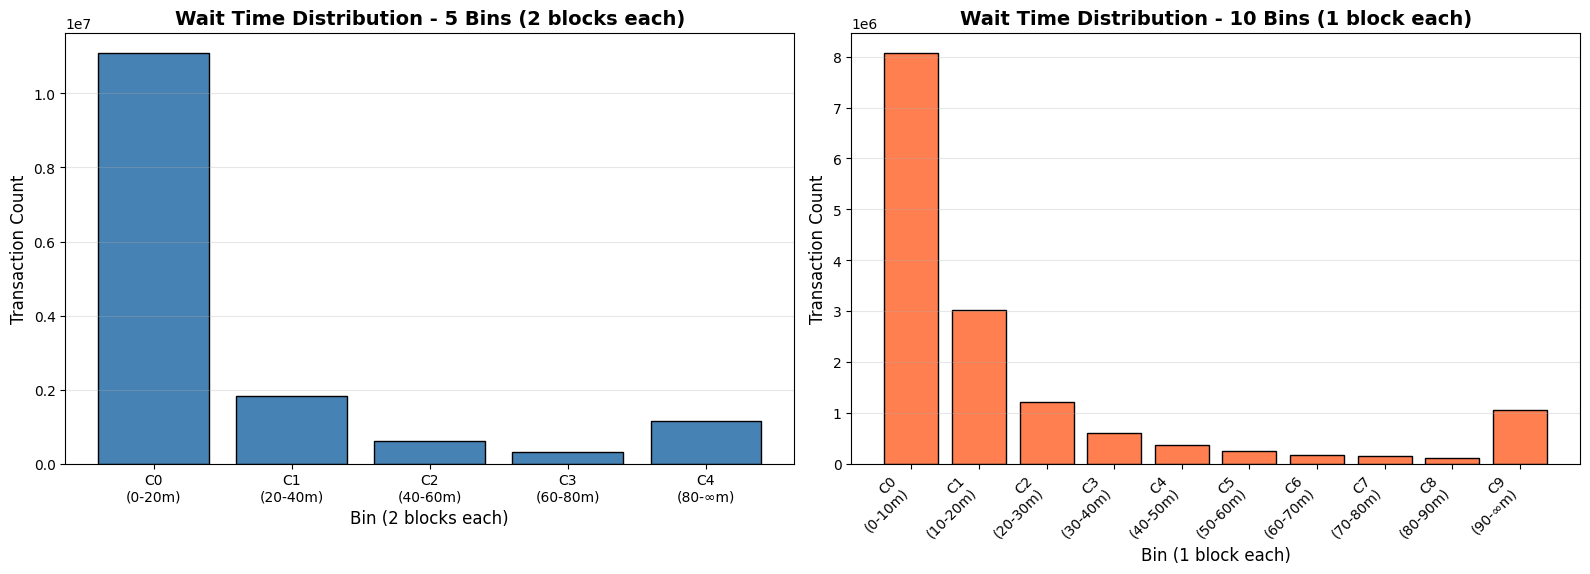

In [ ]:
# Create block-based bins for waittime
# Assuming average block time = 10 minutes = 600 seconds

print("="*80)
print("CREATING BLOCK-BASED BINS FOR WAITTIME")
print("="*80)

MINUTES_PER_BLOCK = 10
SECONDS_PER_BLOCK = MINUTES_PER_BLOCK * 60

# Define bin edges based on blocks
# Using 5 bins of 2 blocks each (as discussed)
N_BINS_5 = 5
BIN_EDGES_5_MINUTES = [0, 20, 40, 60, 80, float('inf')]
BIN_EDGES_5_SECONDS = [m * 60 for m in BIN_EDGES_5_MINUTES]
BIN_LABELS_5 = [
    "0-2 blocks (0-20 min)",
    "2-4 blocks (20-40 min)",
    "4-6 blocks (40-60 min)",
    "6-8 blocks (60-80 min)",
    "8+ blocks (80+ min)"
]

# Also create 10 bins for finer granularity (1 block each)
N_BINS_10 = 10
BIN_EDGES_10_MINUTES = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, float('inf')]
BIN_EDGES_10_SECONDS = [m * 60 for m in BIN_EDGES_10_MINUTES]
BIN_LABELS_10 = [
    "0-1 blocks (0-10 min)",
    "1-2 blocks (10-20 min)",
    "2-3 blocks (20-30 min)",
    "3-4 blocks (30-40 min)",
    "4-5 blocks (40-50 min)",
    "5-6 blocks (50-60 min)",
    "6-7 blocks (60-70 min)",
    "7-8 blocks (70-80 min)",
    "8-9 blocks (80-90 min)",
    "9+ blocks (90+ min)"
]

# Create binned columns
if 'waittime' in txs.columns:
    # 5-bin version (2 blocks per bin)
    txs['waittime_bin_5'] = pd.cut(
        txs['waittime'], 
        bins=BIN_EDGES_5_SECONDS,
        labels=range(N_BINS_5),
        include_lowest=True
    ).astype(float)  # Convert to float to handle NaN
    
    # 10-bin version (1 block per bin)
    txs['waittime_bin_10'] = pd.cut(
        txs['waittime'], 
        bins=BIN_EDGES_10_SECONDS,
        labels=range(N_BINS_10),
        include_lowest=True
    ).astype(float)
    
    print(f"\n✓ Created 'waittime_bin_5' - 5 bins (2 blocks each)")
    print(f"✓ Created 'waittime_bin_10' - 10 bins (1 block each)")
    
    # Show distribution for 5-bin version
    print(f"\n{'='*80}")
    print("5-BIN DISTRIBUTION (2 blocks per bin)")
    print(f"{'='*80}")
    for i in range(N_BINS_5):
        count = (txs['waittime_bin_5'] == i).sum()
        pct = count / txs['waittime_bin_5'].notna().sum() * 100
        print(f"  Class {i} - {BIN_LABELS_5[i]:30s}: {count:,} ({pct:.1f}%)")
    
    # Show distribution for 10-bin version
    print(f"\n{'='*80}")
    print("10-BIN DISTRIBUTION (1 block per bin)")
    print(f"{'='*80}")
    for i in range(N_BINS_10):
        count = (txs['waittime_bin_10'] == i).sum()
        pct = count / txs['waittime_bin_10'].notna().sum() * 100
        print(f"  Class {i} - {BIN_LABELS_10[i]:30s}: {count:,} ({pct:.1f}%)")
    
    # Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 5-bin distribution
bin_5_counts = [((txs['waittime_bin_5'] == i).sum()) for i in range(N_BINS_5)]
axes[0].bar(range(N_BINS_5), bin_5_counts, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Bin (2 blocks each)', fontsize=12)
axes[0].set_ylabel('Transaction Count', fontsize=12)
axes[0].set_title('Wait Time Distribution - 5 Bins (2 blocks each)', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(N_BINS_5))
# Create labels with proper conditional formatting
labels_5 = []
for i in range(N_BINS_5):
    upper = "∞" if BIN_EDGES_5_MINUTES[i+1] == float("inf") else f"{BIN_EDGES_5_MINUTES[i+1]:.0f}"
    labels_5.append(f'C{i}\n({BIN_EDGES_5_MINUTES[i]:.0f}-{upper}m)')
axes[0].set_xticklabels(labels_5, rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

# 10-bin distribution
bin_10_counts = [((txs['waittime_bin_10'] == i).sum()) for i in range(N_BINS_10)]
axes[1].bar(range(N_BINS_10), bin_10_counts, color='coral', edgecolor='black')
axes[1].set_xlabel('Bin (1 block each)', fontsize=12)
axes[1].set_ylabel('Transaction Count', fontsize=12)
axes[1].set_title('Wait Time Distribution - 10 Bins (1 block each)', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(N_BINS_10))
# Create labels with proper conditional formatting
labels_10 = []
for i in range(N_BINS_10):
    upper = "∞" if BIN_EDGES_10_MINUTES[i+1] == float("inf") else f"{BIN_EDGES_10_MINUTES[i+1]:.0f}"
    labels_10.append(f'C{i}\n({BIN_EDGES_10_MINUTES[i]:.0f}-{upper}m)')
axes[1].set_xticklabels(labels_10, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


RANDOM FOREST PREDICTIONS vs ACTUAL (Block-Based Bins - Extended Range)

Total test samples: 2,996,081
Actual distribution across 10 bins
Predicted distribution across 10 bins


/tmp/ipykernel_149752/1197391769.py:119: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/kristian/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


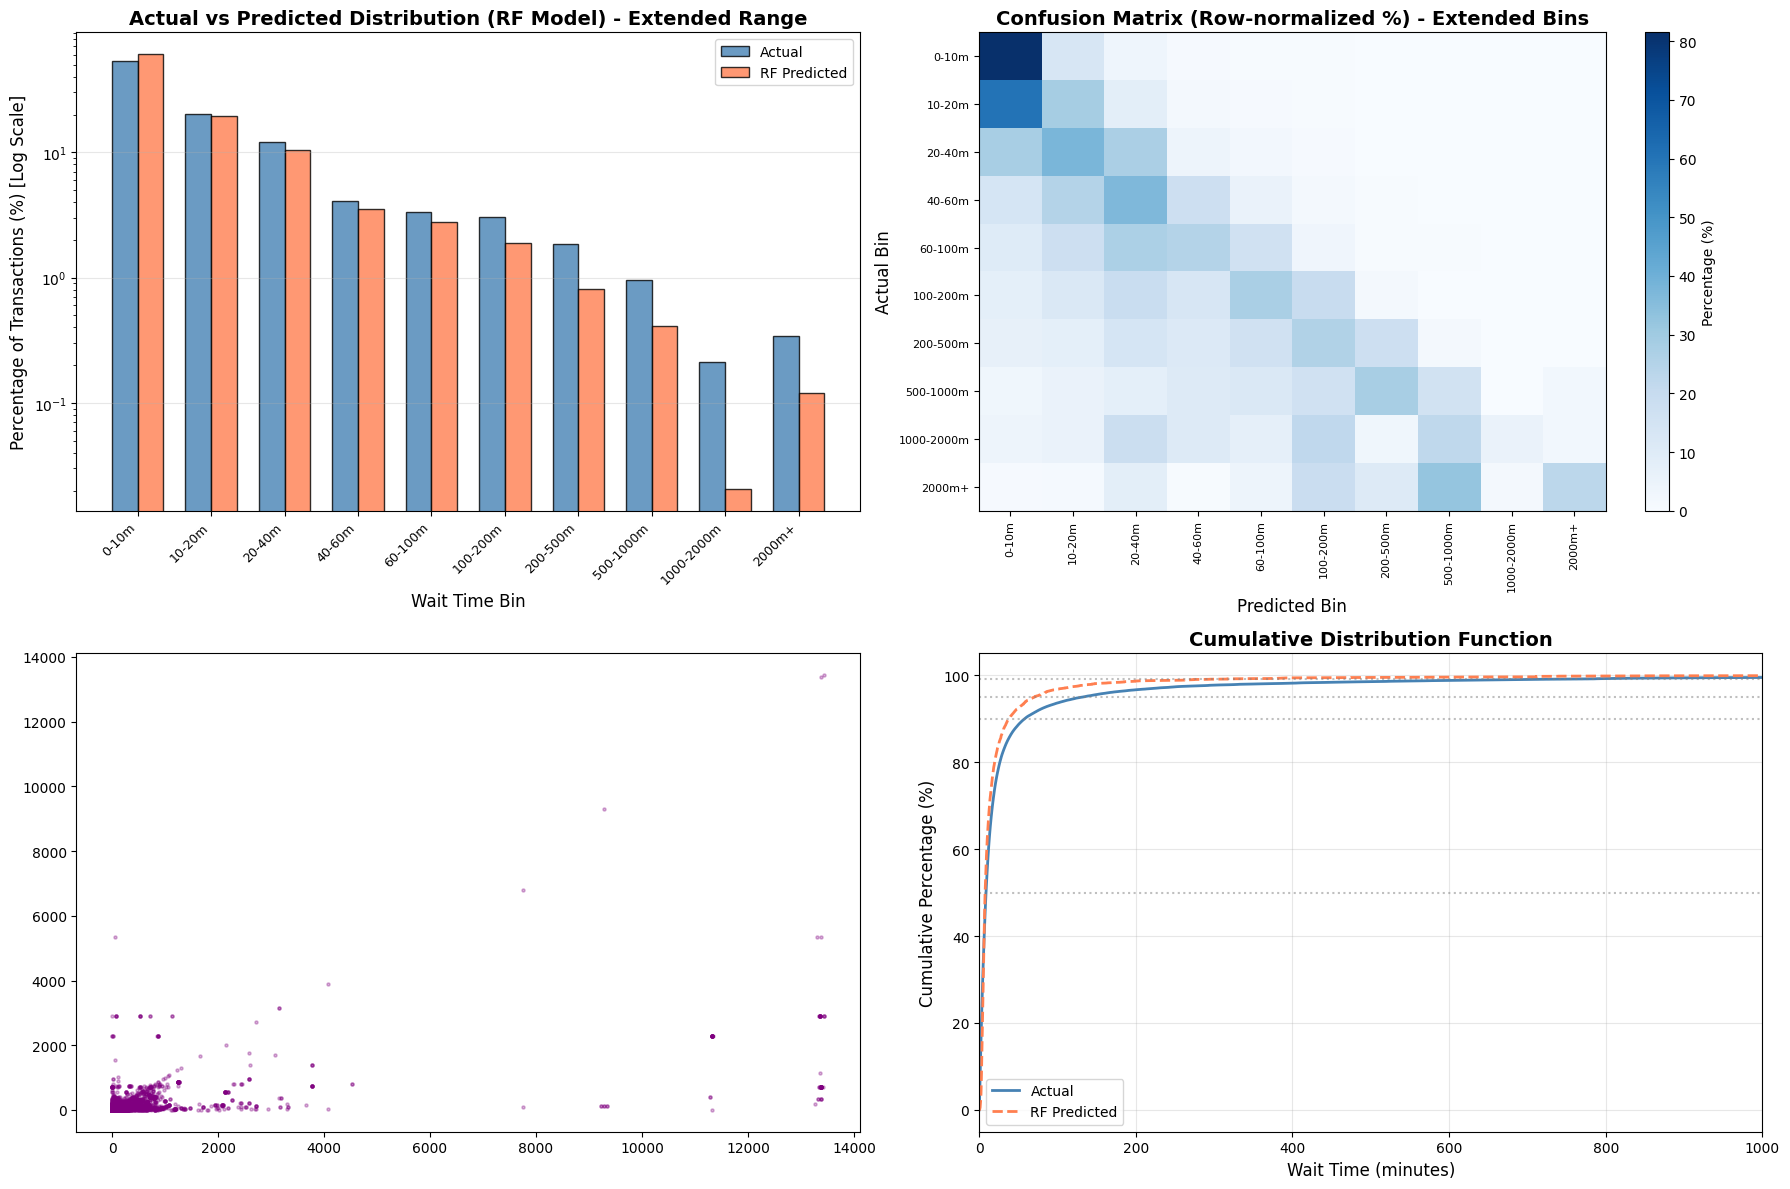


CLASSIFICATION ACCURACY (Extended Bins)
Exact bin accuracy: 55.32%
Within ±1 bin accuracy: 85.54%
Within ±2 bins accuracy: 94.46%

DISTRIBUTION COMPARISON (Top 10 Bins by Count)
Bin             Actual %     Predicted %  Difference   Actual Count   
--------------------------------------------------------------------------------
0-10m                53.82%      60.73%      +6.92%     1,612,402
10-20m               20.17%      19.41%      -0.76%       604,277
20-40m               12.16%      10.36%      -1.80%       364,248
40-60m                4.08%       3.50%      -0.58%       122,198
60-100m               3.36%       2.76%      -0.61%       100,757
100-200m              3.03%       1.88%      -1.15%        90,846
200-500m              1.87%       0.82%      -1.05%        55,940
500-1000m             0.96%       0.41%      -0.55%        28,718
2000m+                0.34%       0.12%      -0.22%        10,281
1000-2000m            0.21%       0.02%      -0.19%         6,414

OUTLIER 

In [8]:
# Visualize Random Forest predictions vs actual using block-based bins
# Visualize Random Forest predictions vs actual using block-based bins
print("="*80)
print("RANDOM FOREST PREDICTIONS vs ACTUAL (Block-Based Bins - Extended Range)")
print("="*80)


# Convert predictions back to original scale (seconds)
y_test_actual = np.expm1(y_test)  # Actual wait times in seconds
y_pred_actual = np.expm1(y_pred)  # Predicted wait times in seconds

# Convert to minutes for easier interpretation
y_test_minutes = y_test_actual / 60
y_pred_minutes = y_pred_actual / 60

# Convert to numpy arrays for easier indexing
y_test_minutes = np.array(y_test_minutes)
y_pred_minutes = np.array(y_pred_minutes)

# Define 10 bins for simpler visualization
BIN_EDGES_EXTENDED_MINUTES = [0, 10, 20, 40, 60, 100, 200, 500, 1000, 2000, float('inf')]
BIN_LABELS_EXTENDED = [
    "0-10m", "10-20m", "20-40m", "40-60m", "60-100m", 
    "100-200m", "200-500m", "500-1000m", "1000-2000m", "2000m+"
]
N_BINS_EXTENDED = len(BIN_LABELS_EXTENDED)

# Assign to bins for actual and predicted
def assign_to_bin_extended(wait_minutes):
    """Assign wait time (in minutes) to appropriate extended bin."""
    for i, edge in enumerate(BIN_EDGES_EXTENDED_MINUTES[1:]):
        if wait_minutes < edge:
            return i
    return len(BIN_EDGES_EXTENDED_MINUTES) - 2  # Last bin

# Create bin assignments
actual_bins = np.array([assign_to_bin_extended(w) for w in y_test_minutes])
predicted_bins = np.array([assign_to_bin_extended(w) for w in y_pred_minutes])

# Calculate distribution for actual vs predicted
actual_dist = [(actual_bins == i).sum() for i in range(N_BINS_EXTENDED)]
predicted_dist = [(predicted_bins == i).sum() for i in range(N_BINS_EXTENDED)]

# Normalize to percentages
total_samples = len(actual_bins)
actual_pct = [count / total_samples * 100 for count in actual_dist]
predicted_pct = [count / total_samples * 100 for count in predicted_dist]

print(f"\nTotal test samples: {total_samples:,}")
print(f"Actual distribution across {N_BINS_EXTENDED} bins")
print(f"Predicted distribution across {N_BINS_EXTENDED} bins")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Side-by-side comparison of distributions (log scale for y-axis)
x_pos = np.arange(N_BINS_EXTENDED)
width = 0.35

axes[0, 0].bar(x_pos - width/2, actual_pct, width, label='Actual', color='steelblue', edgecolor='black', alpha=0.8)
axes[0, 0].bar(x_pos + width/2, predicted_pct, width, label='RF Predicted', color='coral', edgecolor='black', alpha=0.8)
axes[0, 0].set_xlabel('Wait Time Bin', fontsize=12)
axes[0, 0].set_ylabel('Percentage of Transactions (%) [Log Scale]', fontsize=12)
axes[0, 0].set_title('Actual vs Predicted Distribution (RF Model) - Extended Range', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(BIN_LABELS_EXTENDED, rotation=45, ha='right', fontsize=9)
axes[0, 0].legend()
axes[0, 0].set_yscale('log')  # Use log scale to see outliers better
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Confusion Matrix (Actual vs Predicted Bins) - Heatmap
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(actual_bins, predicted_bins)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Row-wise percentage

im = axes[0, 1].imshow(cm_normalized, cmap='Blues', aspect='auto', interpolation='nearest')
axes[0, 1].set_xlabel('Predicted Bin', fontsize=12)
axes[0, 1].set_ylabel('Actual Bin', fontsize=12)
axes[0, 1].set_title('Confusion Matrix (Row-normalized %) - Extended Bins', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(range(N_BINS_EXTENDED))
axes[0, 1].set_yticks(range(N_BINS_EXTENDED))
axes[0, 1].set_xticklabels(BIN_LABELS_EXTENDED, rotation=90, fontsize=8)
axes[0, 1].set_yticklabels(BIN_LABELS_EXTENDED, fontsize=8)
plt.colorbar(im, ax=axes[0, 1], label='Percentage (%)')

# Plot 3: Scatter plot of actual vs predicted (extended range to 1000 minutes)
# Subsample for performance if needed
n_plot = min(50000, len(y_test_minutes))
if n_plot < len(y_test_minutes):
    plot_indices = np.random.choice(len(y_test_minutes), n_plot, replace=False)
    y_test_plot = y_test_minutes[plot_indices]
    y_pred_plot = y_pred_minutes[plot_indices]
else:
    y_test_plot = y_test_minutes
    y_pred_plot = y_pred_minutes

axes[1, 0].scatter(y_test_plot, y_pred_plot, alpha=0.3, s=5, color='purple')

# Plot 4: Cumulative Distribution Comparison
actual_sorted = np.sort(y_test_minutes)
predicted_sorted = np.sort(y_pred_minutes)
actual_cumulative = np.arange(1, len(actual_sorted) + 1) / len(actual_sorted) * 100
predicted_cumulative = np.arange(1, len(predicted_sorted) + 1) / len(predicted_sorted) * 100

axes[1, 1].plot(actual_sorted, actual_cumulative, label='Actual', color='steelblue', linewidth=2)
axes[1, 1].plot(predicted_sorted, predicted_cumulative, label='RF Predicted', color='coral', linewidth=2, linestyle='--')
axes[1, 1].set_xlabel('Wait Time (minutes)', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Percentage (%)', fontsize=12)
axes[1, 1].set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 1000)
axes[1, 1].axhline(y=50, color='gray', linestyle=':', alpha=0.5)
axes[1, 1].axhline(y=90, color='gray', linestyle=':', alpha=0.5)
axes[1, 1].axhline(y=95, color='gray', linestyle=':', alpha=0.5)
axes[1, 1].axhline(y=99, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*80}")
print("CLASSIFICATION ACCURACY (Extended Bins)")
print(f"{'='*80}")
accuracy = (actual_bins == predicted_bins).mean() * 100
print(f"Exact bin accuracy: {accuracy:.2f}%")

# Within 1 bin accuracy
within_1_bin = (np.abs(actual_bins - predicted_bins) <= 1).mean() * 100
print(f"Within ±1 bin accuracy: {within_1_bin:.2f}%")

# Within 2 bins accuracy
within_2_bins = (np.abs(actual_bins - predicted_bins) <= 2).mean() * 100
print(f"Within ±2 bins accuracy: {within_2_bins:.2f}%")

print(f"\n{'='*80}")
print("DISTRIBUTION COMPARISON (Top 10 Bins by Count)")
print(f"{'='*80}")
print(f"{'Bin':<15} {'Actual %':<12} {'Predicted %':<12} {'Difference':<12} {'Actual Count':<15}")
print(f"{'-'*80}")

# Sort bins by actual count (descending) and show top 10
bin_order = np.argsort(actual_dist)[::-1][:10]
for idx in bin_order:
    diff = predicted_pct[idx] - actual_pct[idx]
    print(f"{BIN_LABELS_EXTENDED[idx]:<15} {actual_pct[idx]:>10.2f}% {predicted_pct[idx]:>10.2f}% {diff:>+10.2f}% {actual_dist[idx]:>13,}")

print(f"\n{'='*80}")
print("OUTLIER ANALYSIS (High Wait Times)")
print(f"{'='*80}")
high_waittime_bins = [i for i in range(N_BINS_EXTENDED) if BIN_EDGES_EXTENDED_MINUTES[i] >= 200]
print(f"Bins with wait time >= 200 minutes:")
for idx in high_waittime_bins:
    if actual_dist[idx] > 0:
        print(f"  {BIN_LABELS_EXTENDED[idx]:<15}: Actual={actual_dist[idx]:>8,} ({actual_pct[idx]:>6.2f}%), "
              f"Predicted={predicted_dist[idx]:>8,} ({predicted_pct[idx]:>6.2f}%)")

print(f"\n{'='*80}")
print("PERCENTILE COMPARISON")
print(f"{'='*80}")
percentiles = [50, 75, 90, 95, 99]
print(f"{'Percentile':<12} {'Actual (min)':<15} {'Predicted (min)':<15} {'Difference':<15}")
print(f"{'-'*80}")
for p in percentiles:
    actual_p = np.percentile(y_test_minutes, p)
    predicted_p = np.percentile(y_pred_minutes, p)
    diff = predicted_p - actual_p
    print(f"{p}th{'':<9} {actual_p:>13.2f} {predicted_p:>13.2f} {diff:>+13.2f}")

print(f"{'='*80}")


## Understanding Feature Direction: Coefficients vs Importance

**Key Insight:** Random Forest's `feature_importances_` shows **magnitude** (how much it helps), not **direction** (positive or negative relationship).

To see if time_cost is negatively correlated with waittime, we need:
1. **Correlation analysis** - shows direction
2. **Linear regression coefficients** - shows direction AND magnitude
3. **Partial dependence plots** - visualizes the relationship


In [ ]:
# ANALYSIS 1: CORRELATION (Shows Direction!)
print("="*80)
print("CORRELATION ANALYSIS - Direction of Relationships")
print("="*80 + "\n")

# Calculate correlations between features and target
correlations = {}
for col in X.columns:
    corr = df_clean[[col, 'log_waittime']].corr().iloc[0, 1]
    correlations[col] = corr

print("Correlation with log_waittime:")
print(f"{'Feature':<25s} {'Correlation':>12s} {'Interpretation'}")
print("-" * 70)
for feat, corr in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    direction = "↑ feat → ↑ waittime" if corr > 0 else "↑ feat → ↓ waittime"
    print(f"{feat:<25s} {corr:>+11.4f}  {direction}")

print("\n💡 KEY INSIGHT:")
print(f"   time_cost correlation = {correlations.get('log_time_cost', 0):+.4f}")
if correlations.get('log_time_cost', 0) < 0:
    print("   ✓ NEGATIVE correlation confirmed!")
    print("   ✓ Higher time_cost → SHORTER waittime (as expected)")
    print("   ✓ Impatient users (high time_cost) pay more to confirm faster")
else:
    print("   ⚠️ POSITIVE correlation (unexpected)")
    print("   ⚠️ This suggests a different relationship than expected")

# ANALYSIS 2: LINEAR REGRESSION (Shows Coefficients!)
print("\n" + "="*80)
print("LINEAR REGRESSION - Coefficients Show Direction")
print("="*80 + "\n")

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Standardize features for fair coefficient comparison
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train linear model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R² = {r2_lr:.4f}")
print(f"(Compare to Random Forest R² = {r2:.4f})\n")

# Show coefficients
print("Standardized Coefficients (β):")
print(f"{'Feature':<25s} {'Coefficient':>12s} {'Effect'}")
print("-" * 70)

coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

for _, row in coef_df.iterrows():
    effect = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"{row['feature']:<25s} {row['coefficient']:>+11.4f}  {effect} waittime")

print(f"\nIntercept: {lr_model.intercept_:.4f}")

print("\n💡 INTERPRETATION:")
print("   • Positive coefficient: feature increases predicted waittime")
print("   • Negative coefficient: feature DECREASES predicted waittime")
print("   • Magnitude: how much (in log scale units)")

# Highlight time_cost
tc_coef = coef_df[coef_df['feature'] == 'log_time_cost']['coefficient'].values[0]
print(f"\n🎯 time_cost coefficient: {tc_coef:+.4f}")
if tc_coef < 0:
    print("   ✓ Negative coefficient = higher time_cost → SHORTER waittime")
    print("   ✓ This makes sense: impatient users pay more fees")
else:
    print("   ⚠️ Positive coefficient = higher time_cost → LONGER waittime")
    print("   ⚠️ This is counterintuitive and needs investigation")


CORRELATION ANALYSIS - Direction of Relationships

Correlation with log_waittime:
Feature                    Correlation Interpretation
----------------------------------------------------------------------
has_child                     +0.2971  ↑ feat → ↑ waittime
log_time_cost                 +0.2437  ↑ feat → ↑ waittime
rbf_flag                      +0.0565  ↑ feat → ↑ waittime
log_rho_t                     +0.0511  ↑ feat → ↑ waittime
NFT_it                        -0.0112  ↑ feat → ↓ waittime

💡 KEY INSIGHT:
   time_cost correlation = +0.2437
   ⚠️ POSITIVE correlation (unexpected)
   ⚠️ This suggests a different relationship than expected

LINEAR REGRESSION - Coefficients Show Direction

Linear Regression R² = 0.1076
(Compare to Random Forest R² = 0.4431)

Standardized Coefficients (β):
Feature                    Coefficient Effect
----------------------------------------------------------------------
has_child                     +0.4219  increases waittime
log_rho_t             

In [ ]:
#describe exchange_is_sender and exchange_is_receiver
print(txs['exchange_is_sender'].describe())
print("########################")
print(txs['exchange_is_receiver'].describe())

count     14986355
unique           1
top          False
freq      14986355
Name: exchange_is_sender, dtype: object
########################
count     14986355
unique           1
top          False
freq      14986355
Name: exchange_is_receiver, dtype: object


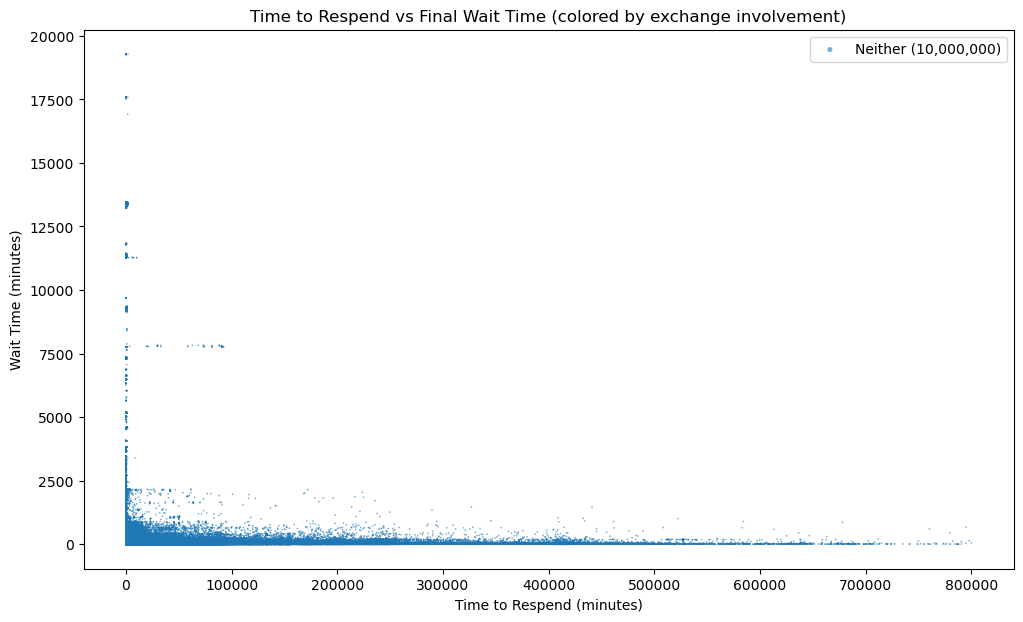

Correlation between time-to-respend and wait-time: -0.008

Exchange Involvement:
  Neither: 10,000,000 (100.0%)
  Exchange Sender: 0 (0.0%)
  Exchange Receiver: 0 (0.0%)
  Both: 0 (0.0%)


In [ ]:
# Scatter: blocks to respend vs wait time (for respent txs only)
# Color-coded by exchange involvement

# Build plotting dataframe and drop NaNs to avoid color mapping issues
plot_df = pd.DataFrame({
    'blocks_to_respend': txs['min_respend_blocks'],
    'wait_time_min': (txs['waittime'] / 60),
    'exchange_is_sender': txs['exchange_is_sender'],
    'exchange_is_receiver': txs['exchange_is_receiver']
}).dropna()

# Create exchange category
# 0 = Neither, 1 = Sender only, 2 = Receiver only, 3 = Both
plot_df['exchange_category'] = 0  # Default: neither
plot_df.loc[plot_df['exchange_is_sender'] & ~plot_df['exchange_is_receiver'], 'exchange_category'] = 1
plot_df.loc[~plot_df['exchange_is_sender'] & plot_df['exchange_is_receiver'], 'exchange_category'] = 2
plot_df.loc[plot_df['exchange_is_sender'] & plot_df['exchange_is_receiver'], 'exchange_category'] = 3

# Optional downsample for rendering performance
max_points = 10000000
if len(plot_df) > max_points:
    plot_df = plot_df.sample(max_points, random_state=42)

# Define colors and labels for each category
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
labels = ['Neither', 'Exchange Sender', 'Exchange Receiver', 'Both']
category_counts = plot_df['exchange_category'].value_counts().sort_index()

plt.figure(figsize=(12, 7))

# Plot each category separately to create legend
for cat in range(4):
    mask = plot_df['exchange_category'] == cat
    if mask.sum() > 0:
        plt.scatter(
            plot_df.loc[mask, 'blocks_to_respend'],
            plot_df.loc[mask, 'wait_time_min'],
            c=colors[cat],
            s=6,
            marker='.',
            edgecolors='none',
            alpha=0.6,
            label=f'{labels[cat]} ({category_counts.get(cat, 0):,})'
        )

plt.xlabel('Blocks to Respend')
plt.ylabel('Wait Time (minutes)')
plt.title('Blocks to Respend vs Final Wait Time (colored by exchange involvement)')
plt.legend(loc='upper right', markerscale=3)
plt.xlim(-1, 50)  # Focus on first 50 blocks
plt.show()

# Correlation (uncolored)
valid_mask = txs['waittime'].notna() & txs['min_respend_blocks'].notna()
corr = np.corrcoef(txs.loc[valid_mask, 'waittime'], txs.loc[valid_mask, 'min_respend_blocks'])[0, 1]
print(f"Correlation between blocks-to-respend and wait-time: {corr:.3f}")

# Exchange involvement stats
print(f"\nExchange Involvement:")
print(f"  Neither: {category_counts.get(0, 0):,} ({category_counts.get(0, 0)/len(plot_df):.1%})")
print(f"  Exchange Sender: {category_counts.get(1, 0):,} ({category_counts.get(1, 0)/len(plot_df):.1%})")
print(f"  Exchange Receiver: {category_counts.get(2, 0):,} ({category_counts.get(2, 0)/len(plot_df):.1%})")
print(f"  Both: {category_counts.get(3, 0):,} ({category_counts.get(3, 0)/len(plot_df):.1%})")

In [7]:
"""
EXPORT PHASE 2 RESULTS FOR PHASE 3
===================================
This cell exports the trained model's predictions in the format required by Phase 3.
"""

print("="*80)
print("EXPORTING PHASE 2 RESULTS FOR PHASE 3")
print("="*80)

# Step 1: Prepare the full dataset for predictions
print("\n[1/6] Preparing full dataset for predictions...")
export_df = txs_with_congestion.copy()

# Ensure we have numeric timestamp column
if 'found_at_ts' not in export_df.columns:
    if export_df['found_at'].dtype == 'object' or pd.api.types.is_datetime64_any_dtype(export_df['found_at']):
        export_df['found_at_ts'] = pd.to_datetime(export_df['found_at']).astype('int64') // 10**9
    else:
        export_df['found_at_ts'] = export_df['found_at']

# Create required features
export_df['has_child'] = export_df['child_txid'].notna().astype(int)
export_df['rbf_flag'] = txs['rbf_fee_total'].notna().astype(int)

# Filter to only the clean data we used for training (same time period)
first_gap_start = pd.Timestamp('2025-08-22 17:49:10').timestamp()
export_df = export_df[export_df['found_at_ts'] < first_gap_start].copy()

# Log-transform features
export_df['log_rho_t'] = np.log1p(export_df['rho_t'])
export_df['log_time_cost'] = np.log1p(export_df['time_cost'])

print(f"  ✓ Dataset size: {len(export_df):,} transactions")

# Step 2: Make predictions on the full dataset
print("\n[2/6] Generating W_hat predictions...")

# Prepare feature matrix (same features as training - must match exactly!)
feature_cols = ['log_rho_t', 'log_time_cost', 'has_child', 'rbf_flag', 'NFT_it']

# Only make predictions where we have all required features
valid_features = export_df[feature_cols].notna().all(axis=1)
print(f"  Valid feature rows: {valid_features.sum():,} ({valid_features.sum()/len(export_df)*100:.1f}%)")

# Initialize W_hat column
export_df['W_hat'] = np.nan

# Make predictions for rows with valid features
X_full = export_df.loc[valid_features, feature_cols]
y_pred_log = model.predict(X_full)

# Inverse transform to get actual waittime predictions (expm1 reverses log1p)
export_df.loc[valid_features, 'W_hat'] = np.expm1(y_pred_log)

print(f"  ✓ Generated predictions for {valid_features.sum():,} transactions")
print(f"  Mean predicted waittime: {export_df['W_hat'].mean():.2f} seconds")
print(f"  Mean actual waittime: {export_df['waittime'].mean():.2f} seconds")

# Step 3: Create time_cost_quantile (bin time_cost into 10 quantiles per epoch)
print("\n[3/6] Creating time_cost_quantile bins...")

# Create quantile bins per epoch (Q_MAX = 10 as per mission plan)
Q_MAX = 10

def assign_quantiles(group):
    """Assign quantile bins (1-10) based on time_cost within each epoch"""
    # Use qcut to create equal-frequency bins
    # Labels 1-10 (higher quantile = higher time_cost = more impatient)
    try:
        group['time_cost_quantile'] = pd.qcut(
            group['time_cost'], 
            q=Q_MAX, 
            labels=range(1, Q_MAX + 1),
            duplicates='drop'
        ).astype(float)
    except ValueError:
        # If we can't create Q_MAX bins (not enough unique values), assign based on percentile
        percentiles = np.linspace(0, 100, Q_MAX + 1)
        bins = np.percentile(group['time_cost'].dropna(), percentiles)
        bins = np.unique(bins)  # Remove duplicates
        if len(bins) > 1:
            group['time_cost_quantile'] = pd.cut(
                group['time_cost'],
                bins=bins,
                labels=range(1, len(bins)),
                include_lowest=True
            ).astype(float)
        else:
            group['time_cost_quantile'] = 1.0
    return group

# Apply quantile binning per epoch
export_df = export_df.groupby('epoch', group_keys=False).apply(assign_quantiles)

print(f"  ✓ Created quantile bins for {export_df['time_cost_quantile'].notna().sum():,} transactions")
print(f"  Quantile distribution:")
for q in range(1, Q_MAX + 1):
    count = (export_df['time_cost_quantile'] == q).sum()
    print(f"    Quantile {q:2d}: {count:8,} transactions")

# Step 4: Compute F_tq (upper-tail probability distribution)
print("\n[4/6] Computing F_tq (tail distribution)...")

# F^t(q) = P(time_cost >= quantile q | epoch t)
# For each epoch-quantile pair, compute the fraction of transactions in quantile q or higher
tail_dist = []

for epoch in sorted(export_df['epoch'].dropna().unique()):
    epoch_data = export_df[export_df['epoch'] == epoch]
    total_count = len(epoch_data.dropna(subset=['time_cost_quantile']))
    
    if total_count == 0:
        continue
    
    for q in range(1, Q_MAX + 1):
        # Count transactions in quantile q and above
        upper_tail_count = len(epoch_data[epoch_data['time_cost_quantile'] >= q])
        F_tq = upper_tail_count / total_count if total_count > 0 else 0
        
        tail_dist.append({
            'epoch': epoch,
            'quantile': q,
            'F_tq': F_tq
        })

tail_df = pd.DataFrame(tail_dist)

# Merge F_tq back to main dataframe
export_df = export_df.merge(
    tail_df,
    left_on=['epoch', 'time_cost_quantile'],
    right_on=['epoch', 'quantile'],
    how='left',
    suffixes=('', '_merged')
)

# Clean up the merge
if 'quantile' in export_df.columns:
    export_df = export_df.drop(columns=['quantile'])

print(f"  ✓ Computed F_tq for {len(tail_df)} epoch-quantile pairs")
print(f"  F_tq statistics:")
print(f"    Mean: {export_df['F_tq'].mean():.4f}")
print(f"    Min: {export_df['F_tq'].min():.4f}, Max: {export_df['F_tq'].max():.4f}")

# Step 5: Add datetime for convenience
print("\n[5/6] Adding datetime columns...")
# Handle both string and numeric timestamp formats
if export_df['found_at'].dtype == 'object':
    export_df['found_dt'] = pd.to_datetime(export_df['found_at'])
else:
    export_df['found_dt'] = pd.to_datetime(export_df['found_at'], unit='s')

if export_df['mined_at'].dtype == 'object':
    export_df['mined_dt'] = pd.to_datetime(export_df['mined_at'])
else:
    export_df['mined_dt'] = pd.to_datetime(export_df['mined_at'], unit='s')
print(f"  ✓ Added datetime columns")

# Step 6: Select and save ONLY DERIVED columns for Phase 3
# (columns not already in the SQLite database)
print("\n[6/6] Saving Phase 2 derived columns...")

# Only export columns COMPUTED by Phase 2 (not in original data)
# These can be joined back to original data using tx_id
derived_cols = [
    # Join key (required to merge with original data)
    'tx_id',
    
    # Phase 2 computed outputs
    'W_hat',              # Predicted waittime (model output)
    'rho_t',              # Mempool congestion metric (computed)
    'time_cost',          # Time cost metric (computed)
    'time_cost_quantile', # Quantile bins per epoch (computed)
    'F_tq',               # Tail distribution function (computed)
    'epoch',              # Time window identifier (computed)
]

# Keep only columns that exist
phase2_results = export_df[[col for col in derived_cols if col in export_df.columns]].copy()

# Save to pickle
output_path = '/home/kristian/notebooks/phase2_derived_features.pkl'
phase2_results.to_pickle(output_path)

print(f"\n  ✓ Saved Phase 2 derived features to: {output_path}")
print(f"  Rows: {len(phase2_results):,}")
print(f"  Columns: {len(phase2_results.columns)}")
print(f"\n  Derived columns exported (join with original data on tx_id):")
for col in derived_cols:
    if col in phase2_results.columns:
        non_null = phase2_results[col].notna().sum()
        print(f"    {col:20s}: {non_null:10,} non-null ({non_null/len(phase2_results)*100:5.1f}%)")

print(f"\n  Note: Original data columns (fee_rate, weight, waittime, etc.)")
print(f"        should be loaded from the SQLite database and joined on tx_id")

# Step 7: Validation checks
print("\n" + "="*80)
print("VALIDATION CHECKS")
print("="*80)

# Check 1: W_hat predictions valid
print(f"✓ W_hat predictions: {phase2_results['W_hat'].notna().sum():,} valid predictions")
print(f"  Mean W_hat: {phase2_results['W_hat'].mean():.2f} seconds")

# Check 2: Distribution of quantiles
print(f"✓ Quantile distribution balanced: ", end="")
quantile_counts = phase2_results['time_cost_quantile'].value_counts().sort_index()
if len(quantile_counts) == Q_MAX:
    print(f"Yes ({len(quantile_counts)} bins)")
else:
    print(f"Partial ({len(quantile_counts)} of {Q_MAX} bins)")

# Check 3: F_tq monotonicity (should decrease as quantile increases)
print(f"✓ F_tq monotonicity: ", end="")
ftq_by_quantile = phase2_results.groupby('time_cost_quantile')['F_tq'].mean().sort_index()
is_monotonic = (ftq_by_quantile.diff().dropna() <= 0).all()
print(f"{'Correct' if is_monotonic else 'Check required'}")

# Check 4: All derived columns present
print(f"✓ Derived columns present: ", end="")
required_derived = ['tx_id', 'W_hat', 'rho_t', 'time_cost_quantile', 'F_tq', 'epoch']
missing = [col for col in required_derived if col not in phase2_results.columns]
if not missing:
    print("All present")
else:
    print(f"Missing: {missing}")

print("\n" + "="*80)
print("EXPORT COMPLETE!")
print("="*80)
print(f"\n✓ Phase 2 derived features saved to: {output_path}")
print(f"✓ File size: {len(phase2_results):,} rows, {len(phase2_results.columns)} columns")
print(f"\n✓ To use in Phase 3:")
print(f"  1. Load original data from SQLite database")
print(f"  2. Load this pickle file")
print(f"  3. Join on tx_id to get derived features")
print("="*80)


EXPORTING PHASE 2 RESULTS FOR PHASE 3

[1/6] Preparing full dataset for predictions...


: 